# STEAM 상위 50개의 게임 이탈률 분석

# 0. 라이브러리 설정

In [19]:
import os
import re
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from tqdm.auto import tqdm

# scikit-learn
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)

# imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# models
from lightgbm import LGBMClassifier

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)


### 0. 데이터 확인

In [2]:
df = pd.read_csv('./data/steam_reviews_last365d.csv')   # STEAM 1년치 데이터

C:\Users\Playdata\AppData\Local\Temp\ipykernel_9200\1627804435.py:1: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/steam_reviews_last365d.csv')   # STEAM 1년치 데이터


In [3]:
df.columns

Index(['appid', 'recommendationid', 'steamid', 'num_games_owned',
       'num_reviews_author', 'playtime_forever', 'playtime_last_two_weeks',
       'playtime_at_review', 'deck_playtime_at_review', 'last_played',
       'language', 'review', 'timestamp_created', 'timestamp_updated',
       'voted_up', 'votes_up', 'votes_funny', 'weighted_vote_score',
       'comment_count', 'steam_purchase', 'received_for_free',
       'written_during_early_access', 'developer_response',
       'timestamp_dev_responded', 'primarily_steam_deck'],
      dtype='object')

### 0.1. 컬럼명 및 설명


| 컬럼명(한글) | 컬럼명(영어) | 설명 | 분포(실제 분포) |
|---|---|---|---|
| 게임 ID | appid | Steam 게임 고유 ID | 440 ~ 3,241,660 (mean≈1,239,968) |
| 리뷰 추천 ID | recommendationid | 리뷰 고유 식별자 | 약 1.99e8 ~ 2.15e8 |
| 유저 Steam ID | steamid | 리뷰 작성자 Steam ID | 거의 단일값, 분산 매우 작음 |
| 보유 게임 수 | num_games_owned | 유저가 보유한 전체 게임 수 | 0 ~ 7,706 (median 0, mean 55.9) |
| 작성 리뷰 수 | num_reviews_author | 유저가 작성한 전체 리뷰 수 | 1 ~ 2,542 (median 3) |
| 누적 플레이 타임 | playtime_forever | 해당 게임 총 플레이 시간 | 5 ~ 1,457,369 |
| 최근 2주 플레이 타임 | playtime_last_two_weeks | 최근 2주간 플레이 시간 | 0 ~ 17,144 (75% ≤ 370) |
| 리뷰 시점 플레이 타임 | playtime_at_review | 리뷰 작성 시점 누적 플레이 시간 | 5 ~ 1,396,679 |
| Steam Deck 플레이 타임 | deck_playtime_at_review | 리뷰 시점 Steam Deck 플레이 시간 | 1 ~ 51,724 (표본 적음) |
| 마지막 플레이 시각 | last_played | 마지막 플레이 시점 (Unix) | 1.47e9 ~ 1.77e9 |
| 리뷰 생성 시각 | timestamp_created | 리뷰 최초 작성 시각 (Unix) | 1.75e9 ~ 1.77e9 |
| 리뷰 수정 시각 | timestamp_updated | 리뷰 최종 수정 시각 (Unix) | 생성 시각과 거의 동일 |
| 긍정 추천 여부 | voted_up | 긍정 리뷰 여부 (1=긍정) | mean 0.633 (긍정 약 63%) |
| 도움됨 투표 수 | votes_up | 도움이 됐다고 평가한 수 | 0 ~ 1,511 (대부분 0) |
| 재미있음 투표 수 | votes_funny | 재미있다고 평가한 수 | 0 ~ 438 (대부분 0) |
| 가중 투표 점수 | weighted_vote_score | Steam 내부 도움도 점수 | 0.29 ~ 0.95 (median 0.5) |
| 댓글 수 | comment_count | 리뷰에 달린 댓글 수 | 0 ~ 14 (99% 이상 0) |
| 개발자 응답 시각 | timestamp_dev_responded | 개발자 답변 시각 (Unix) | 존재 데이터 56건 |
| Steam 구매 여부 | steam_purchase | Steam에서 구매했는지 여부 | 없음 |
| 무료 획득 여부 | received_for_free | 무료로 받았는지 여부 | 없음 |
| 얼리액세스 작성 여부 | written_during_early_access | 얼리액세스 중 작성 여부 | 없음 |
| 리뷰 언어 | language | 리뷰 작성 언어 | 없음 |
| 리뷰 텍스트 | review | 리뷰 본문 텍스트 | 없음 |
| 개발자 응답 내용 | developer_response | 개발자 답변 텍스트 | 없음 |
| Steam Deck 주 사용 여부 | primarily_steam_deck | Steam Deck 위주 플레이 여부 | 없음 |
| 중복 appid | appid_1 | appid 중복 컬럼 | appid와 동일 |
| 난수 컬럼 | rnd | 무작위 샘플링용 컬럼 | 0 ~ 0.019 | 

# 1. 데이터 로드 및 정제

### 1.0. 상위 50개 게임으로만 이루어진 데이터 생성

In [4]:
# 상위 50개 게임 데이터
appid_counts = df['appid'].value_counts()
top50_appids = appid_counts.head(50).index.tolist()
df_top50 = df[df['appid'].isin(top50_appids)].copy()

### 1.1. 결측치 확인 및 수정

In [5]:
# 결측치 확인
df_top50.isnull().sum()

appid                                0
recommendationid                     0
steamid                              0
num_games_owned                      0
num_reviews_author                   0
playtime_forever                     0
playtime_last_two_weeks              0
playtime_at_review                   0
deck_playtime_at_review        4736661
last_played                          0
language                             0
review                           15761
timestamp_created                    0
timestamp_updated                    0
voted_up                             0
votes_up                             0
votes_funny                          0
weighted_vote_score                  0
comment_count                        0
steam_purchase                       0
received_for_free                    0
written_during_early_access          0
developer_response             4824716
timestamp_dev_responded        4824716
primarily_steam_deck                 0
dtype: int64

In [6]:
# 결측치 있는 컬럼들 모두 제거
df_model = df_top50.drop(columns=['deck_playtime_at_review', 'developer_response', 'timestamp_dev_responded'])
df_model.isnull().sum()

appid                              0
recommendationid                   0
steamid                            0
num_games_owned                    0
num_reviews_author                 0
playtime_forever                   0
playtime_last_two_weeks            0
playtime_at_review                 0
last_played                        0
language                           0
review                         15761
timestamp_created                  0
timestamp_updated                  0
voted_up                           0
votes_up                           0
votes_funny                        0
weighted_vote_score                0
comment_count                      0
steam_purchase                     0
received_for_free                  0
written_during_early_access        0
primarily_steam_deck               0
dtype: int64

In [7]:
df_model

,appid,recommendationid,steamid,num_games_owned,num_reviews_author,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,language,...,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,primarily_steam_deck
27798,2139460,215256415,76561198092089560,0,1,1659,1659,1628.0,1767647101,english,...,1767645356,True,0,0,0.50000,0,False,False,False,False
27799,2139460,215256182,76561197995642012,0,4,370,367,339.0,1767646994,french,...,1767645190,True,0,0,0.50000,0,False,False,False,False
27800,2139460,215249671,76561198217416651,0,32,552,552,401.0,1767648127,greek,...,1767640383,True,0,0,0.50000,0,False,False,False,False
27801,2139460,215246874,76561198111964424,0,16,146,0,146.0,1765836608,russian,...,1767638383,False,0,0,0.50000,0,False,False,False,False
27802,2139460,215244452,76561198000529800,85,1,47556,276,47519.0,1767638299,english,...,1767636538,True,0,0,0.50000,0,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5447568,570,192652367,76561199824228518,79,7,49329,9264,5671.0,1767667012,russian,...,1757669172,True,0,0,0.50000,0,False,True,False,False
5447569,570,192652315,76561199509986279,0,1,129565,591,79079.0,1767661292,russian,...,1744542216,False,0,0,0.50000,0,False,False,False,False
5447570,570,192652264,76561199699553706,21,4,36710,548,28793.0,1767315372,russian,...,1762351962,True,0,0,0.50000,0,False,False,False,False
5447571,570,192652232,76561199815094533,2,1,3633,0,1422.0,1766312795,russian,...,1744542138,True,1,0,0.52381,1,False,False,False,False


### 1.2. game_stlye 매핑

- 상위 50개 게임 기반으로 appid, game_style 매핑
    - online (지속 접속형 / 서비스형 게임) 멀티플레이성 / 플레이 패턴이 짧고 빈번   
    - story (엔딩 소비형 / 완결형 게임) 스토리 엔딩 / 플레이 기간 짧고 집중적 / 엔딩 후 접속 없는게 정상  
    - video (지속 싱글/샌드박스형) 싱글플레이 중심 / 엔딩이후에도 콘텐츠 존재

In [8]:
# Top50 기반으로 매핑 
# 기존 29개에 없던 appid도 포함해서 업데이트

STYLE_MAP = {
    3241660: "online",  # R.E.P.O
    2807960: "online",  # Battlefield™ 6
    730:     "online",  # Counter-Strike 2
    1808500: "online",  # ARC Raiders
    1030300: "story",   # Hollow Knight: Silksong
    570:     "online",  # Dota 2
    578080:  "online",  # PUBG
    2246340: "video",   # Monster Hunter Wilds
    2592160: "story",   # Dispatch
    553850:  "online",  # HELLDIVERS™ 2
    3240220: "online",  # Grand Theft Auto V Enhanced
    1091500: "story",   # Cyberpunk 2077
    1903340: "video",   # Clair Obscur: Expedition 33
    2001120: "story",   # Split Fiction
    1245620: "video",   # Elden Ring
    1086940: "video",   # Baldur's Gate 3
    1144200: "online",  # Ready or Not
    3167020: "video",   # Escape From Duckov
    3564740: "online",  # Where Winds Meet
    227300:  "video",   # Euro Truck Simulator 2
    108600:  "video",   # Project Zomboid
    413150:  "video",   # Stardew Valley
    1771300: "video",   # Kingdom Come 2
    3489700: "story",   # Stellar Blade™
    1172470: "online",  # Apex
    1222140: "story",   # Detroit: Become Human
    1326470: "video",   # Sons Of The Forest
    990080:  "story",   # Hogwarts Legacy
    1551360: "video",   # Forza Horizon 5
    1623730: "video",   # Palworld
    1145350: "video",   # Hades II
    2183900: "story",   # Space Marine AE
    230410:  "online",  # Warframe
    2139460: "online",  # Once Human
    236390:  "online",  # War Thunder
    440:     "online",  # Team Fortress 2
    1973530: "online",  # Limbus Company
    394360:  "video",   # Hearts of Iron IV
    3932890: "online",  # Escape from Tarkov
    526870:  "video",   # Satisfactory
    3513350: "online",  # Wuthering Waves
    3405690: "online",  # EA SPORTS FC™ 26
    2622380: "video",   # ELDEN RING NIGHTREIGN
    814380:  "video",   # Sekiro™: Shadows Die Twice - GOTY Edition
    648800:  "video",   # Raft
    3159330: "story",   # Assassin’s Creed Shadows
    3527290: "video",   # PEAK
    2651280: "story",   # Spider-Man 2
    294100:  "video",   # RimWorld
    1222670: "video",   # The Sims 4
}


# game_style 컬럼 생성
df_model["game_style"] = df_model["appid"].map(STYLE_MAP)
df_model["game_style"].value_counts()


game_style
online    2467704
video     1427383
story      935797
Name: count, dtype: int64

### 1.3. 'review' 결측 및 공백 행 제거  

- review 결측 appid별 분포 확인 구문

In [9]:
# appid별 review 결측치 분포
review_na_by_app = (
    df_model.groupby("appid")["review"]
      .apply(lambda s: s.isna().sum())
      .rename("review_na_cnt")
      .to_frame()
)

# appid별 전체 행 수
total_by_app = df_model.groupby("appid").size().rename("total_cnt").to_frame()

# 합치기 + 비율
review_na_stats = (
    total_by_app.join(review_na_by_app, how="left")
                .fillna({"review_na_cnt": 0})
)

review_na_stats["review_na_ratio"] = review_na_stats["review_na_cnt"] / review_na_stats["total_cnt"]

# 결측치 많은 순으로 확인
review_na_stats.sort_values("review_na_cnt", ascending=False).head(30)


,total_cnt,review_na_cnt,review_na_ratio
appid,,,
3241660,341851,1067,0.003121
2807960,301260,1051,0.003489
1808500,253341,991,0.003912
3240220,139431,675,0.004841
730,273327,668,0.002444
1091500,120404,566,0.004701
553850,148578,510,0.003433
578080,194464,500,0.002571
1030300,239171,493,0.002061


- churn 라벨 생성 전 review가 NaN인 행 드롭

In [10]:
# review NaN 드롭
before = len(df_model)
df_model = df_model[df_model["review"].notna()].copy()
after = len(df_model)

print(f"[drop NaN review] before={before:,} -> after={after:,} (dropped {before-after:,})")


[drop NaN review] before=4,830,884 -> after=4,815,123 (dropped 15,761)


In [11]:
df_model[['review']].isna().sum()

review    0
dtype: int64

- appid별 공백/빈 문자열 리뷰 개수 확인 구문

In [12]:
# 공백/빈문자열(whitespace-only 포함) 마스크
blank_mask = df_model["review"].astype(str).str.strip().eq("")

blank_by_appid = (
    df_model.assign(is_blank_review=blank_mask)
            .groupby("appid")["is_blank_review"]
            .agg(total_cnt="size", blank_cnt="sum")
)

blank_by_appid["blank_ratio"] = blank_by_appid["blank_cnt"] / blank_by_appid["total_cnt"]

# 공백 리뷰가 있는 appid만, blank_cnt 큰 순으로 보기
blank_by_appid_nonzero = blank_by_appid[blank_by_appid["blank_cnt"] > 0].sort_values("blank_cnt", ascending=False)

display(blank_by_appid_nonzero.head(50))
print("공백 리뷰 총 개수:", int(blank_mask.sum()))

,total_cnt,blank_cnt,blank_ratio
appid,,,
730,272659,186,0.000682
3241660,340784,159,0.000467
3240220,138756,130,0.000937
2807960,300209,121,0.000403
578080,193964,111,0.000572
570,204123,94,0.000461
227300,92225,74,0.000802
1808500,252350,73,0.000289
1030300,238678,59,0.000247


공백 리뷰 총 개수: 1902


- 공백/빈 문자열 리뷰 드롭

In [13]:
# 공백/빈 문자열 리뷰 드롭
before = len(df_model)

blank_mask = df_model["review"].astype(str).str.strip().eq("")
df_model = df_model[~blank_mask].copy()

after = len(df_model)
print(f"[drop blank review] before={before:,} -> after={after:,} (dropped {before-after:,})")


[drop blank review] before=4,815,123 -> after=4,813,221 (dropped 1,902)


### 1.4. 이탈 타겟 생성

- churn 라벨 생성 (style별 기준일 적용)

In [14]:
# style별 churn 기준일(일 단위)
STYLE_WINDOW_DAYS = {
    "online": 7,
    "video": 10,
    "story": 5,
}

# 리뷰 시각 / 마지막 플레이 시각
review_dt = pd.to_datetime(df_model["timestamp_created"], unit="s", errors="coerce")
last_dt   = pd.to_datetime(df_model["last_played"], unit="s", errors="coerce")

# 리뷰 이후 며칠 뒤에 마지막 플레이가 있었는지
df_model["days_after_review"] = (last_dt - review_dt).dt.days

# game_style별 기준일 매핑 (none은 NaN)
df_model["churn_window_days"] = df_model["game_style"].map(STYLE_WINDOW_DAYS)

# 기본 churn: days_after_review < window 이면 churn=1 (떠난 것)
# - window가 없는(none) 행은 일단 NaN으로 둠(나중에 제외/처리)
df_model["churn"] = df_model["days_after_review"] < df_model["churn_window_days"].astype(int)


# 예외 처리(기존에 하던 규칙 유지)
df_model.loc[df_model["last_played"] == 0, "churn"] = 1
df_model.loc[df_model["days_after_review"] < 0, "churn"] = 1

print(df_model["churn"].value_counts(dropna=False).sort_index())


churn
False    3432753
True     1380468
Name: count, dtype: int64


C:\Users\Playdata\AppData\Local\Temp\ipykernel_9200\831698950.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_model.loc[df_model["last_played"] == 0, "churn"] = 1


In [15]:
df_model[['language']].nunique()

language    30
dtype: int64

In [16]:
df_model.describe()

,appid,recommendationid,steamid,num_games_owned,num_reviews_author,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,timestamp_created,timestamp_updated,votes_up,votes_funny,weighted_vote_score,comment_count,days_after_review,churn_window_days
count,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06,4.813221e+06
mean,1.637917e+06,2.034422e+08,7.656120e+16,7.224943e+01,1.093352e+01,1.398406e+04,4.346475e+02,1.067346e+04,1.761394e+09,1.756335e+09,1.756654e+09,1.038864e+00,1.820704e-01,5.029349e-01,6.856697e-02,5.806457e+01,7.498542e+00
std,1.156278e+06,8.342337e+06,6.190886e+08,2.492080e+02,6.318230e+01,4.066221e+04,1.151922e+03,3.810909e+04,1.145637e+07,8.849875e+06,8.803059e+06,3.084613e+01,6.968658e+00,2.391883e-02,2.379588e+00,1.368769e+02,1.784596e+00
min,4.400000e+02,1.848840e+08,7.656120e+16,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,1.736122e+09,1.736122e+09,0.000000e+00,0.000000e+00,2.213739e-02,0.000000e+00,-2.044100e+04,5.000000e+00
25%,5.780800e+05,1.967549e+08,7.656120e+16,0.000000e+00,2.000000e+00,1.500000e+03,0.000000e+00,6.490000e+02,1.759989e+09,1.749423e+09,1.749911e+09,0.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,4.000000e+00,7.000000e+00
50%,1.551360e+06,2.059368e+08,7.656120e+16,0.000000e+00,4.000000e+00,4.166000e+03,0.000000e+00,2.093000e+03,1.765025e+09,1.759660e+09,1.760116e+09,0.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,3.400000e+01,7.000000e+00
75%,2.807960e+06,2.102846e+08,7.656120e+16,6.900000e+01,1.000000e+01,1.034100e+04,2.330000e+02,6.120000e+03,1.767091e+09,1.764041e+09,1.764091e+09,0.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,1.020000e+02,1.000000e+01
max,3.932890e+06,2.152792e+08,7.656120e+16,3.816800e+04,1.974800e+04,2.919994e+06,3.664700e+04,2.789459e+06,1.767667e+09,1.767666e+09,1.767666e+09,2.009800e+04,6.372000e+03,9.958196e-01,4.500000e+03,3.640000e+02,1.000000e+01


### 1.5. 파생변수 생성
- 텍스트 기반 good_review 파생변수 생성 구문

In [17]:
# 1) 언어별 키워드 사전
# - phrases: 문장/구문(부분일치 OK)
# - words: 단어성 키워드(라틴권은 단어경계 \b 적용)
# - neg: 부정 구문(걸리면 good=0으로 처리)
# - boundary: words에 \b를 붙일지 여부 (중국어/일본어/태국어/한국어는 보통 False)
LEXICON = {
    # English
    "english": {
        "phrases": [
            r"highly recommend(?:ed)?",
            r"definitely recommend",
            r"worth (?:buying|it|the money|the time)",
            r"great game",
            r"amazing game",
            r"awesome game",
            r"best game(?:s)?",
        ],
        "words": [
            r"awesome", r"amazing", r"great", r"excellent", r"fantastic", r"incredible",
            r"masterpiece", r"perfect", r"love", r"fun", r"enjoy", r"recommend", r"worth",
        ],
        "neg": [
            r"not\s+good", r"not\s+great", r"not\s+worth",
            r"(?:do\s*not|don't|dont)\s+recommend",
            r"(?:do\s*not|don't|dont)\s+buy",
            r"can't\s+recommend|cant\s+recommend",
            r"avoid\b", r"refund\b",
        ],
        "boundary": True,
    },

    # Spanish (Spain) + LatAm는 같이 처리
    "spanish": {
        "phrases": [r"muy bueno", r"vale la pena", r"lo recomiendo", r"recomendad[oa]"],
        "words": [r"genial", r"excelente", r"buen[oa]", r"incre[ií]ble", r"recomiendo", r"recomendar"],
        "neg": [r"no\s+recomiendo", r"no\s+vale\s+la\s+pena", r"no\s+es\s+buen[oa]", r"no\s+merece\s+la\s+pena", r"no\s+compr(?:es|ar)"],
        "boundary": True,
    },
    "latam": {  # 라틴아메리카 스페인어
        "phrases": [r"muy bueno", r"vale la pena", r"lo recomiendo", r"recomendad[oa]"],
        "words": [r"genial", r"excelente", r"buen[oa]", r"incre[ií]ble", r"recomiendo", r"recomendar"],
        "neg": [r"no\s+recomiendo", r"no\s+vale\s+la\s+pena", r"no\s+es\s+buen[oa]", r"no\s+merece\s+la\s+pena", r"no\s+compr(?:es|ar)"],
        "boundary": True,
    },

    # Portuguese (PT / BR)
    "portuguese": {
        "phrases": [r"vale a pena", r"recomendo", r"muito bom", r"jogo (?:muito )?bom"],
        "words": [r"ótimo", r"excelente", r"incr[ií]vel", r"perfeito", r"divertido", r"recomendar"],
        "neg": [r"não\s+recomendo", r"nao\s+recomendo", r"não\s+vale\s+a\s+pena", r"nao\s+vale\s+a\s+pena", r"não\s+é\s+bom", r"nao\s+e\s+bom", r"não\s+compr(?:e|ar)", r"nao\s+compr(?:e|ar)"],
        "boundary": True,
    },
    "brazilian": {  # 브라질 포르투갈어
        "phrases": [r"vale a pena", r"recomendo", r"muito bom", r"jogo (?:muito )?bom"],
        "words": [r"ótimo", r"excelente", r"incr[ií]vel", r"perfeito", r"divertido", r"recomendar"],
        "neg": [r"não\s+recomendo", r"nao\s+recomendo", r"não\s+vale\s+a\s+pena", r"nao\s+vale\s+a\s+pena", r"não\s+é\s+bom", r"nao\s+e\s+bom", r"não\s+compr(?:e|ar)", r"nao\s+compr(?:e|ar)"],
        "boundary": True,
    },

    # German
    "german": {
        "phrases": [r"sehr gut", r"klare(?:s)? empfehlung", r"lohnt sich", r"absolut empfehl"],
        "words": [r"genial", r"toll", r"super", r"großartig", r"exzellent", r"empfehle", r"empfehlenswert"],
        "neg": [r"nicht\s+empfehl", r"lohnt\s+sich\s+nicht", r"nicht\s+gut", r"kau(?:f|ft)\s+nicht", r"kein\s+kauf"],
        "boundary": True,
    },

    # French
    "french": {
        "phrases": [r"je recommande", r"vaut le coup", r"tr[eè]s bon", r"excellent jeu"],
        "words": [r"g[eé]nial", r"excellent", r"super", r"incroyable", r"parfait", r"recommande"],
        "neg": [r"je\s+ne\s+recommande\s+pas", r"ne\s+vaut\s+pas\s+le\s+coup", r"pas\s+bon", r"n['’]achetez\s+pas", r"n['’]ach[eè]te\s+pas"],
        "boundary": True,
    },

    # Italian
    "italian": {
        "phrases": [r"lo consiglio", r"vale la pena", r"molto bello", r"gioco (?:molto )?bello"],
        "words": [r"fantastico", r"ottimo", r"eccellente", r"stupendo", r"divertente", r"consiglio", r"consigliare"],
        "neg": [r"non\s+lo\s+consiglio", r"non\s+vale\s+la\s+pena", r"non\s+[eè]\s+bello", r"non\s+compr(?:are|atelo)"],
        "boundary": True,
    },

    # Dutch
    "dutch": {
        "phrases": [r"zeker aanraden", r"de moeite waard", r"heel goed", r"geweldig spel"],
        "words": [r"geweldig", r"fantastisch", r"super", r"leuk", r"aanraden", r"aanbevelen", r"waarde"],
        "neg": [r"niet\s+aanrad", r"niet\s+de\s+moeite\s+waard", r"niet\s+goed", r"koop\s+niet"],
        "boundary": True,
    },

    # Swedish / Norwegian / Danish / Finnish
    "swedish": {
        "phrases": [r"rekommenderar", r"värt det", r"jättebra", r"riktigt bra"],
        "words": [r"fantastisk", r"grym", r"suverän", r"toppen", r"kul", r"rekommendera", r"värd"],
        "neg": [r"rekommenderar\s+inte", r"inte\s+värt", r"inte\s+bra", r"köp\s+inte"],
        "boundary": True,
    },
    "norwegian": {
        "phrases": [r"anbefaler", r"verdt det", r"kjempebra", r"veldig bra"],
        "words": [r"fantastisk", r"råbra", r"suveren", r"gøy", r"anbefale", r"verdt"],
        "neg": [r"anbefaler\s+ikke", r"ikke\s+verdt", r"ikke\s+bra", r"ikke\s+kjøp"],
        "boundary": True,
    },
    "danish": {
        "phrases": [r"anbefaler", r"v[æa]rd at", r"mega god", r"rigtig god"],
        "words": [r"fantastisk", r"fremragende", r"super", r"sjov", r"anbefale", r"v[æa]rd"],
        "neg": [r"anbefaler\s+ikke", r"ikke\s+v[æa]rd", r"ikke\s+god", r"k[oø]b\s+ikke"],
        "boundary": True,
    },
    "finnish": {
        "phrases": [r"suosittelen", r"todella hyv[äa]", r"sen arvoinen", r"hyv[äa] peli"],
        "words": [r"loistava", r"mahtava", r"erinomainen", r"hauska", r"suositella", r"arvoinen"],
        "neg": [r"en\s+suosittele", r"ei\s+kannata", r"ei\s+hyv[äa]", r"älä\s+osta"],
        "boundary": True,
    },

    # Polish / Czech / Romanian / Hungarian / Bulgarian / Greek / Ukrainian / Russian / Turkish
    "polish": {
        "phrases": [r"polecam", r"warto", r"świetna gra", r"bardzo dobra"],
        "words": [r"świetn[aey]", r"super", r"rewelacyjna", r"doskonała", r"polecić", r"warto"],
        "neg": [r"nie\s+polecam", r"nie\s+warto", r"nie\s+jest\s+dobr", r"nie\s+kupuj"],
        "boundary": True,
    },
    "czech": {
        "phrases": [r"doporu[čc]uji", r"stoj[ií]\s+za\s+to", r"skv[ěe]l[aá]", r"v[ýy]born[aá]"],
        "words": [r"super", r"skv[ěe]l", r"v[ýy]born", r"bav[ií]", r"doporu[čc]it"],
        "neg": [r"nedoporu[čc]uji", r"nestoj[ií]\s+za\s+to", r"nen[ií]\s+dobr", r"nekupuj"],
        "boundary": True,
    },
    "romanian": {
        "phrases": [r"recomand", r"merit[ăa]", r"foarte bun", r"joc (?:foarte )?bun"],
        "words": [r"excelent", r"minunat", r"super", r"recomanda", r"merit"],
        "neg": [r"nu\s+recomand", r"nu\s+merit[ăa]", r"nu\s+e\s+bun", r"nu\s+cump[ăa]ra"],
        "boundary": True,
    },
    "hungarian": {
        "phrases": [r"aj[aá]nlom", r"meg[eé]ri", r"nagyon j[oó]", r"szuper j[aá]t[eé]k"],
        "words": [r"szuper", r"fantasztikus", r"kiv[aá]l[oó]", r"nagyon", r"aj[aá]nlani", r"meg[eé]r"],
        "neg": [r"nem\s+aj[aá]nlom", r"nem\s+[eé]ri\s+meg", r"nem\s+j[oó]", r"ne\s+vedd\s+meg"],
        "boundary": True,
    },
    "bulgarian": {
        "phrases": [r"препоръч", r"много добра", r"страхотна", r"заслужава си"],
        "words": [r"страхот", r"отлич", r"супер", r"препоръч", r"шедьовър"],
        "neg": [r"не\s+препоръч", r"не\s+си\s+струва", r"не\s+е\s+доб", r"не\s+купувай"],
        "boundary": False,  # кир릴은 \b가 애매해서 단순부분일치로
    },
    "greek": {
        "phrases": [r"το\s+προτείν", r"αξίζει", r"πολύ\s+καλ", r"εξαιρετικ"],
        "words": [r"τέλει", r"φοβε", r"εξαιρετικ", r"καταπληκτικ", r"προτείν", r"αξίζ"],
        "neg": [r"δεν\s+προτείν", r"δεν\s+αξίζ", r"δεν\s+είναι\s+καλ", r"μην\s+αγοράσ"],
        "boundary": False,
    },
    "ukrainian": {
        "phrases": [r"рекоменд", r"дуже\s+хорош", r"варто", r"чудов"],
        "words": [r"відмін", r"класн", r"шедевр", r"рекоменд", r"варто"],
        "neg": [r"не\s+рекоменд", r"не\s+варто", r"не\s+хорош", r"не\s+купуй"],
        "boundary": False,
    },
    "russian": {
        "phrases": [r"рекоменд", r"очень\s+хорош", r"стоит", r"шедевр"],
        "words": [r"отлич", r"классн", r"супер", r"шедевр", r"рекоменд", r"стоит"],
        "neg": [r"не\s+рекоменд", r"не\s+стоит", r"плох", r"не\s+покупай", r"не\s+берите"],
        "boundary": False,
    },
    "turkish": {
        "phrases": [r"kesinlikle tavsiye", r"tavsiye ederim", r"çok iyi", r"mükemmel", r"harika"],
        "words": [r"güzel", r"mükemmel", r"harika", r"şahane", r"tavsiye", r"değer"],
        "neg": [r"tavsiye etmem", r"tavsiye etmiyorum", r"iyi değil", r"alma", r"almayın", r"değmez"],
        "boundary": True,
    },

    # Korean / Japanese / Chinese / Arabic / Thai / Vietnamese / Indonesian
    "koreana": {
        "phrases": [r"강추", r"완전 추천", r"강력 추천", r"갓겜", r"명작", r"존잼", r"개꿀잼", r"재밌", r"재미있"],
        "words": [r"추천", r"최고", r"꿀잼", r"재미", r"좋다", r"훌륭", r"완벽", r"감동"],
        "neg": [r"비추", r"추천\s*안", r"추천\s*하지", r"재미없", r"별로", r"최악", r"사지\s*마", r"사지마", r"환불"],
        "boundary": False,
    },
    "japanese": {
        "phrases": [r"おすすめ", r"オススメ", r"最高", r"神ゲー", r"買う価値", r"面白い", r"楽しい"],
        "words": [r"おすすめ", r"最高", r"神", r"面白", r"楽しい", r"良い", r"素晴らしい"],
        "neg": [r"おすすめしない", r"買わない方が", r"つまらない", r"面白くない", r"最悪", r"返品"],
        "boundary": False,
    },
    "schinese": {
        "phrases": [r"强烈推荐", r"非常推荐", r"值得买", r"值得入", r"很值得", r"很好玩", r"神作", r"精品"],
        "words": [r"推荐", r"值得", r"好玩", r"很好", r"优秀", r"完美", r"喜欢"],
        "neg": [r"不推荐", r"不值得", r"不好玩", r"垃圾", r"别买", r"千万别买", r"退款"],
        "boundary": False,
    },
    "tchinese": {
        "phrases": [r"強烈推薦", r"非常推薦", r"值得買", r"值得入", r"很值得", r"很好玩", r"神作", r"精品"],
        "words": [r"推薦", r"值得", r"好玩", r"很好", r"優秀", r"完美", r"喜歡"],
        "neg": [r"不推薦", r"不值得", r"不好玩", r"垃圾", r"別買", r"千萬別買", r"退款"],
        "boundary": False,
    },
    "arabic": {
        "phrases": [r"أنصح", r"ممتاز", r"رائع", r"يستحق", r"لعبة رائعة", r"ممتعة"],
        "words": [r"ممتاز", r"رائع", r"جميل", r"ممتع", r"يستحق", r"أنصح"],
        "neg": [r"لا\s+أنصح", r"لا\s+يستحق", r"سيئ", r"لا\s+تشتري", r"استرجاع"],
        "boundary": False,
    },
    "thai": {
        "phrases": [r"แนะนำ", r"ดีมาก", r"สุดยอด", r"คุ้มค่า", r"สนุกมาก", r"โคตรสนุก"],
        "words": [r"แนะนำ", r"ดี", r"สนุก", r"สุดยอด", r"คุ้ม", r"ชอบ"],
        "neg": [r"ไม่แนะนำ", r"ไม่คุ้ม", r"ไม่ดี", r"แย่", r"อย่าซื้อ", r"ขอคืนเงิน"],
        "boundary": False,
    },
    "vietnamese": {
        "phrases": [r"rất hay", r"tuyệt vời", r"đáng mua", r"đáng tiền", r"nên mua", r"khuyên dùng"],
        "words": [r"hay", r"tuyệt", r"xuất sắc", r"đáng", r"thích", r"khuyên", r"nên"],
        "neg": [r"không\s+khuyên", r"không\s+đáng", r"đừng\s+mua", r"tệ", r"chán", r"hoàn tiền"],
        "boundary": True,
    },
    "indonesian": {
        "phrases": [r"sangat bagus", r"rekomendasi", r"worth it", r"layak dibeli", r"seru banget"],
        "words": [r"bagus", r"keren", r"mantap", r"seru", r"rekomend", r"layak"],
        "neg": [r"tidak\s+rekomend", r"jangan\s+beli", r"tidak\s+layak", r"jelek", r"buruk", r"refund"],
        "boundary": True,
    },
}

# 없는 언어는 english로 fallback
DEFAULT_LANG = "english"


# 2) 정규식 빌더
def _compile_lexicon(cfg):
    boundary = cfg.get("boundary", True)

    parts_good = []
    for p in cfg.get("phrases", []):
        parts_good.append(f"(?:{p})")
    for w in cfg.get("words", []):
        if boundary:
            parts_good.append(rf"\b{w}\b")
        else:
            parts_good.append(f"(?:{w})")

    good_pat = "|".join(parts_good) if parts_good else r"$^"
    good_re = re.compile(good_pat, flags=re.UNICODE)

    neg_parts = [f"(?:{p})" for p in cfg.get("neg", [])]
    neg_pat = "|".join(neg_parts) if neg_parts else r"$^"
    neg_re = re.compile(neg_pat, flags=re.UNICODE)

    return good_re, neg_re


_COMPILED = {}
for lang, cfg in LEXICON.items():
    _COMPILED[lang] = _compile_lexicon(cfg)
_COMPILED[DEFAULT_LANG] = _COMPILED.get(DEFAULT_LANG, _compile_lexicon(LEXICON["english"]))


def add_good_flag_multilang(df_model, text_col="review", lang_col="language"):
    out = df_model.copy()

    text = out[text_col].fillna("").astype(str).str.casefold()
    lang = out[lang_col].fillna(DEFAULT_LANG).astype(str)

    good_hit = pd.Series(False, index=out.index)
    neg_hit  = pd.Series(False, index=out.index)

    for l in lang.unique():
        mask = (lang == l)
        good_re, neg_re = _COMPILED.get(l, _COMPILED[DEFAULT_LANG])

        good_hit.loc[mask] = text.loc[mask].str.contains(good_re, regex=True)
        neg_hit.loc[mask]  = text.loc[mask].str.contains(neg_re,  regex=True)

    out["good_review"] = (good_hit & (~neg_hit)).astype(int)
    return out


# df_good = add_good_flag_multilang(df, text_col="review", lang_col="language")
# print(df_good["good_review"].value_counts())
df_model = add_good_flag_multilang(df_model, text_col="review", lang_col="language")
print(df_model["good_review"].value_counts())

good_review
0    3525940
1    1287281
Name: count, dtype: int64


- playtime 분포 확인 (원본, 로그)

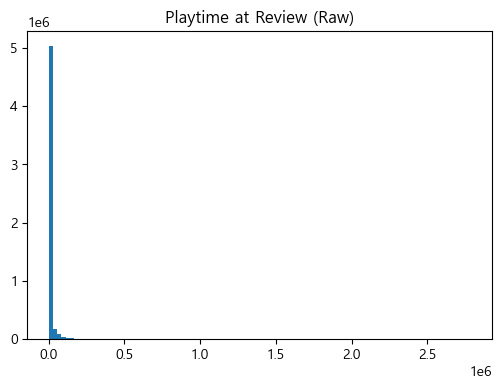

In [21]:
plt.figure(figsize=(6,4))
plt.hist(df['playtime_at_review'], bins=100)
plt.title('Playtime at Review (Raw)')
plt.show()
# 대부분 왼쪽에 몰려 있으면 로그 확정

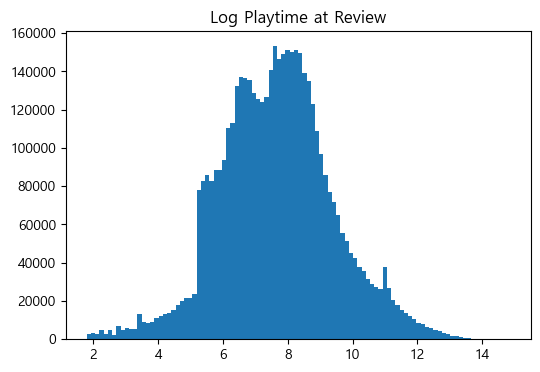

In [23]:
df_model['log_playtime'] = np.log1p(df_model['playtime_at_review'])

plt.figure(figsize=(6,4))
plt.hist(df_model['log_playtime'], bins=100)
plt.title('Log Playtime at Review')
plt.show()
# playtime_stage 구간 나눔 근거 확보 => 파생변수 생성시 로그 사용 필요.

- 추가 파생변수 생성 구문

    - 변수 추가하는 이유  
    => X feature가 “상태 설명”만 하고 “행동 패턴”을 설명하지 못함 (성능 정체)  

    - churn 예측 성능을 올리려면 “값”이 아니라  
    “관계·비율·행동 패턴”을 feature로 만들어야 한다.  

In [18]:
# 1. 리뷰 시점 플레이 집중도
# - 보유 게임 수 대비 해당 게임 몰입도
# 게임 많이 가진데 이 게임만 오래 함 → 비이탈 / 게임 많고 얕게만 함 → 이탈 가능성↑
df_model['playtime_per_game'] = np.log1p(df_model['playtime_at_review'] / (df_model['num_games_owned'] + 1))

# 2. 리뷰 시점 플레이 몰입 단계
# - 플레이타임을 short / mid / long 단계로 구분
df_model['log_playtime'] = np.log1p(df_model['playtime_at_review'])
# 구간 나누기
bins = [-np.inf, 4, 8, np.inf]
labels = ['short', 'mid', 'long']
df_model['playtime_stage'] = pd.cut(
    df_model['log_playtime'],
    bins=bins,
    labels=labels
)

df_model['is_short_play'] = (df_model['playtime_stage'] == 'short').astype(int)
df_model['is_mid_play']   = (df_model['playtime_stage'] == 'mid').astype(int)
df_model['is_long_play']  = (df_model['playtime_stage'] == 'long').astype(int)

# 3. 리뷰어 활동성
# - 게임 수 대비 리뷰 작성 빈도
# 리뷰를 많이 쓰는 사람 → 서비스 잔존율 높음 / 리뷰 거의 안 쓰는 사람 → 이탈 가능성↑
df_model['reviews_per_game'] = np.log1p(df_model['num_reviews_author'] / (df_model['num_games_owned'] + 1))

# 4. 유저 경험 수준
df_model['log_num_games_owned'] = np.log1p(df_model['num_games_owned'])
df_model['log_num_reviews_author'] = np.log1p(df_model['num_reviews_author'])
# 4-1. “경험 많은 유저” 여부
df_model['is_heavy_user'] = (
    (df_model['log_num_games_owned'] > 5.0) & 
    (df_model['log_num_reviews_author'] > 3.5)
).astype(int)
# 4-2. “경험 적은 유저” 여부
df_model['is_light_user'] = (
    (df_model['log_num_games_owned'] < 2.0) &
    (df_model['log_num_reviews_author'] < 1.0)
).astype(int)

# 5. 리뷰 감정 × 플레이 행동
# 5-1. 긍정 리뷰 + 낮은 플레이타임 (= 위험, “좋다고는 했는데 금방 떠난 사람”)
df_model['positive_but_short_play'] = (
    (df_model['good_review'] == 1) & 
    (df_model['playtime_at_review'] < 60)
).astype(int)
# 5-2. 부정 리뷰 + 높은 플레이타임 (= 비이탈, "욕하면서 계속 하는 사람")
df_model['negative_but_long_play'] = (
    (df_model['good_review'] == 0) & 
    (df_model['playtime_at_review'] > 1200)
).astype(int)

# 6. 사회적 반응 여부
df_model['has_votes'] = ((df_model['votes_up'] + df_model['votes_funny']) > 0).astype(int)
df_model['has_comment'] = (df_model['comment_count'] > 0).astype(int)

# 7. 리뷰 수정 여부
# - 리뷰 진정성. (비이탈 그룹에서 높게 나타날 확률이 큼)
# 리뷰를 수정했다는 것은 이탈하지 않고 게임을 지속하며 의견을 업데이트했다는 강력한 증거.
df_model['is_updated_review'] = (df_model['timestamp_created'] != df_model['timestamp_updated']).astype(int)

# 8. 커뮤니티 반응 밀도
# - 커뮤니티 영향력 (리뷰 1개당 평균 반응도)
# 영향력 있는 리뷰어는 커뮤니티 활동 때문에라도 이탈률이 낮게 측정되는 경우가 많음.
df_model['social_density'] = np.log1p((df_model['votes_up'] + df_model['comment_count']) / (df_model['num_reviews_author'] + 1))

# 안전 처리 (inf, -inf 제거)
df_model.replace([np.inf, -np.inf], 0, inplace=True)

df_model.head(3)    # 확인

,appid,recommendationid,steamid,num_games_owned,num_reviews_author,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,language,...,log_num_games_owned,log_num_reviews_author,is_heavy_user,is_light_user,positive_but_short_play,negative_but_long_play,has_votes,has_comment,is_updated_review,social_density
27798,2139460,215256415,76561198092089560,0,1,1659,1659,1628.0,1767647101,english,...,0.0,0.693147,0,1,0,1,0,0,0,0.0
27799,2139460,215256182,76561197995642012,0,4,370,367,339.0,1767646994,french,...,0.0,1.609438,0,0,0,0,0,0,0,0.0
27800,2139460,215249671,76561198217416651,0,32,552,552,401.0,1767648127,greek,...,0.0,3.496508,0,0,0,0,0,0,0,0.0


# 2. EDA 및 그래프 시각화

- STEAM 상위 50개 게임 이탈률 시각화

C:\Users\Playdata\AppData\Local\Temp\ipykernel_9200\105060884.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


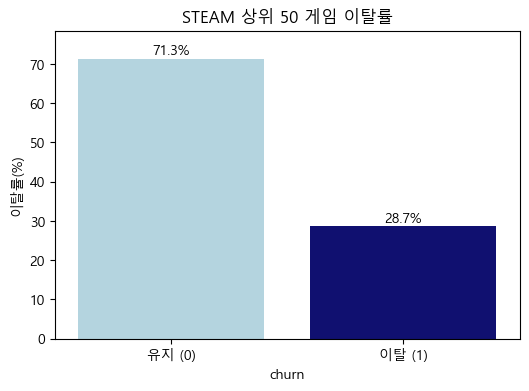

In [50]:
churn_ratio = df_model['churn'].value_counts(normalize=True) * 100

# 시각화
plt.figure(figsize=(6,4))
bars = sns.barplot(
    x=churn_ratio.index, 
    y=churn_ratio.values, 
    palette=["lightblue", "navy"]
)

# title과 axis labels
plt.xticks([0,1], ['유지 (0)', '이탈 (1)'])
plt.ylabel("이탈률(%)")
plt.title("STEAM 상위 50 게임 이탈률")

for bar in bars.patches:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h + 1,
        f"{h:.1f}%",
        ha="center"
    )

plt.ylim(0, 1.1*churn_ratio.max())  # 그래프 상단 여유 공간
plt.show()

- 게임 스타일별 (online, story, video) 보유 게임 수 분포 시각화

C:\Users\Playdata\AppData\Local\Temp\ipykernel_9200\2006231406.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


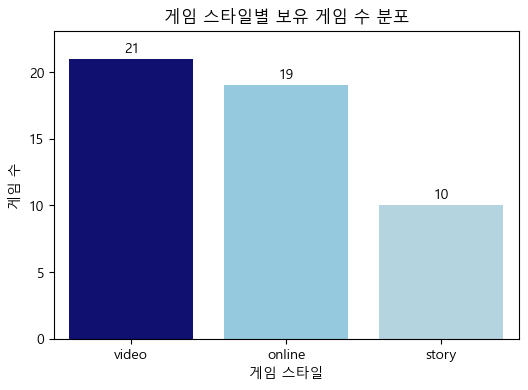

In [53]:
game_counts = df_model.groupby('game_style')['appid'].nunique()
game_counts = game_counts.sort_values(ascending=False)  # 큰 값부터 작은 값으로 정렬
# print("Number of unique games per Game Style:")
# print(game_counts)

# value labels 시각화
plt.figure(figsize=(6,4))
bars = sns.barplot(
    x=game_counts.index,
    y=game_counts.values,
    palette=["navy", "skyblue", "lightblue"]  # 색상도 큰 순서에 맞춰
)

# 바 라벨
for bar in bars.patches:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.5,           # 숫자 위로 조금 띄움
        f"{int(height)}",
        ha='center'
    )

plt.ylabel("게임 수")
plt.xlabel("게임 스타일")
plt.title("게임 스타일별 보유 게임 수 분포")
plt.ylim(0, game_counts.max() * 1.1)  # y축 상단 여유
plt.show()


- 게임 스타일별 (online, story, video) 이탈률 시각화

C:\Users\Playdata\AppData\Local\Temp\ipykernel_9200\1088555760.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


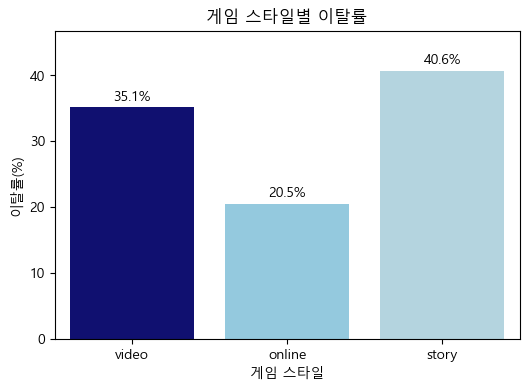

In [54]:
order = ["video", "online", "story"]

style_churn = (
    df_model.groupby('game_style')['churn']
            .mean()
            .mul(100)
            .reset_index()
            # .sort_values(by='churn', ascending=False)  # 이탈률 높은 순
)

# game_style 순서 고정
style_churn['game_style'] = pd.Categorical(
    style_churn['game_style'],
    categories=order,
    ordered=True
)

plt.figure(figsize=(6,4))

ax = sns.barplot(
    data=style_churn,
    x='game_style',
    y='churn',
    palette=[ "navy", "skyblue", "lightblue"]
)

plt.ylabel("이탈률(%)")
plt.xlabel("게임 스타일")
plt.title("게임 스타일별 이탈률")

# 바 위에 퍼센트 라벨 추가
for container in ax.containers:
    ax.bar_label(
        container,
        fmt="%.1f%%",
        padding=3,
        fontsize=10
    )

plt.ylim(0, style_churn['churn'].max() * 1.15)  # 라벨 잘리기 방지
plt.show()

- 숫자형 칼럼과 이탈 칼럼의 상관관계 수치표 및 시각화

In [59]:
# 원본 수치형 컬럼 선택
numeric_cols = [
    'playtime_at_review', 
    'num_games_owned', 
    'num_reviews_author',
    'votes_up', 
    'votes_funny', 
    'comment_count'
]

df_model[numeric_cols].corr()   # 숫자형 변수와 이탈 상관관계 수치표

,playtime_at_review,num_games_owned,num_reviews_author,votes_up,votes_funny,comment_count
playtime_at_review,1.000000,-0.028990,-0.025153,0.001221,0.002624,0.005675
num_games_owned,-0.028990,1.000000,0.357889,0.024668,0.016022,0.027320
num_reviews_author,-0.025153,0.357889,1.000000,0.012385,0.007685,0.008967
votes_up,0.001221,0.024668,0.012385,1.000000,0.525007,0.241287
votes_funny,0.002624,0.016022,0.007685,0.525007,1.000000,0.132761
comment_count,0.005675,0.027320,0.008967,0.241287,0.132761,1.000000


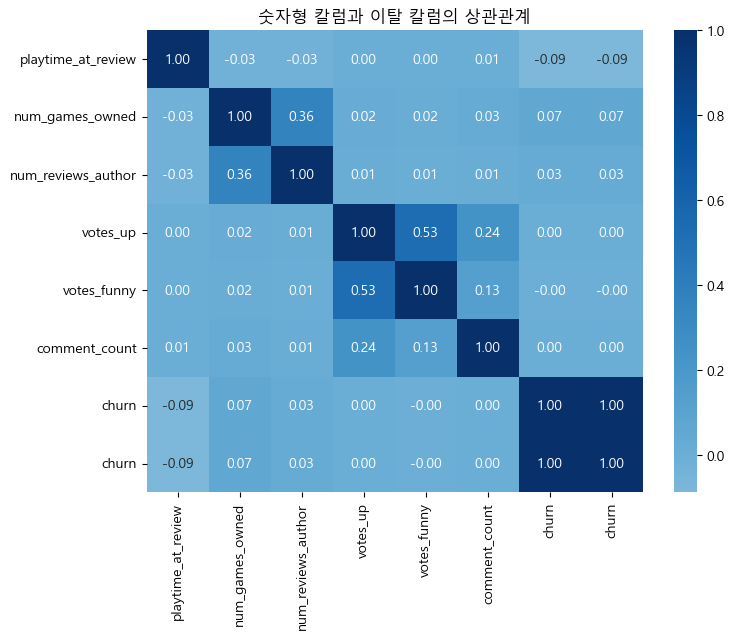

In [60]:
# heatmap에 churn 포함
numeric_cols =  numeric_cols + ['churn']

# 상관계수 계산
corr = df_model[numeric_cols].corr()

# 숫자형 feature heatmap
plt.figure(figsize=(8,6))
corr_numeric = df_model[numeric_cols + ['churn']].corr()
sns.heatmap(corr_numeric, annot=True, fmt=".2f", cmap="Blues", center=0)
plt.title("숫자형 칼럼과 이탈 칼럼의 상관관계")
plt.show()

- 파생변수 컬럼과 이탈 칼럼의 상관관계 수치표 및 시각화

In [58]:
# 파생변수 컬럼 선택
derived_cols = [
    'playtime_per_game', 'is_short_play', 'is_mid_play', 'is_long_play',
    'reviews_per_game', 'is_heavy_user', 'is_light_user',
    'positive_but_short_play', 'negative_but_long_play',
    'has_votes', 'has_comment', 'is_updated_review', 'social_density'
]

df_model[derived_cols].corr()   # 파생변수와 이탈의 상관관계 수치표

,playtime_per_game,is_short_play,is_mid_play,is_long_play,reviews_per_game,is_heavy_user,is_light_user,positive_but_short_play,negative_but_long_play,has_votes,has_comment,is_updated_review,social_density
playtime_per_game,1.000000,-0.212394,-0.408825,0.473144,0.500532,-0.274704,0.367424,-0.091635,0.333604,-0.072700,-0.014754,-0.018597,0.037562
is_short_play,-0.212394,1.000000,-0.165937,-0.123808,0.000297,0.027600,-0.013640,0.412749,-0.133707,0.045914,0.027614,-0.008654,0.026907
is_mid_play,-0.408825,-0.165937,1.000000,-0.958005,0.059674,0.036744,-0.059378,-0.064492,-0.445760,-0.035862,-0.037900,-0.089169,-0.065174
is_long_play,0.473144,-0.123808,-0.958005,1.000000,-0.060134,-0.045000,0.063715,-0.055125,0.487428,0.022736,0.030108,0.092244,0.057757
reviews_per_game,0.500532,0.000297,0.059674,-0.060134,1.000000,-0.130080,-0.109430,-0.005641,-0.068836,0.013266,-0.016785,0.038720,-0.045470
is_heavy_user,-0.274704,0.027600,0.036744,-0.045000,-0.130080,1.000000,-0.087429,0.007369,-0.040442,0.083929,0.030605,0.084049,-0.029187
is_light_user,0.367424,-0.013640,-0.059378,0.063715,-0.109430,-0.087429,1.000000,0.001192,0.047143,-0.069559,-0.019890,-0.085113,0.054770
positive_but_short_play,-0.091635,0.412749,-0.064492,-0.055125,-0.005641,0.007369,0.001192,1.000000,-0.059532,0.003588,0.005464,-0.005654,0.004184
negative_but_long_play,0.333604,-0.133707,-0.445760,0.487428,-0.068836,-0.040442,0.047143,-0.059532,1.000000,0.016502,0.016947,0.051635,0.029256
has_votes,-0.072700,0.045914,-0.035862,0.022736,0.013266,0.083929,-0.069559,0.003588,0.016502,1.000000,0.138316,0.094581,0.497436


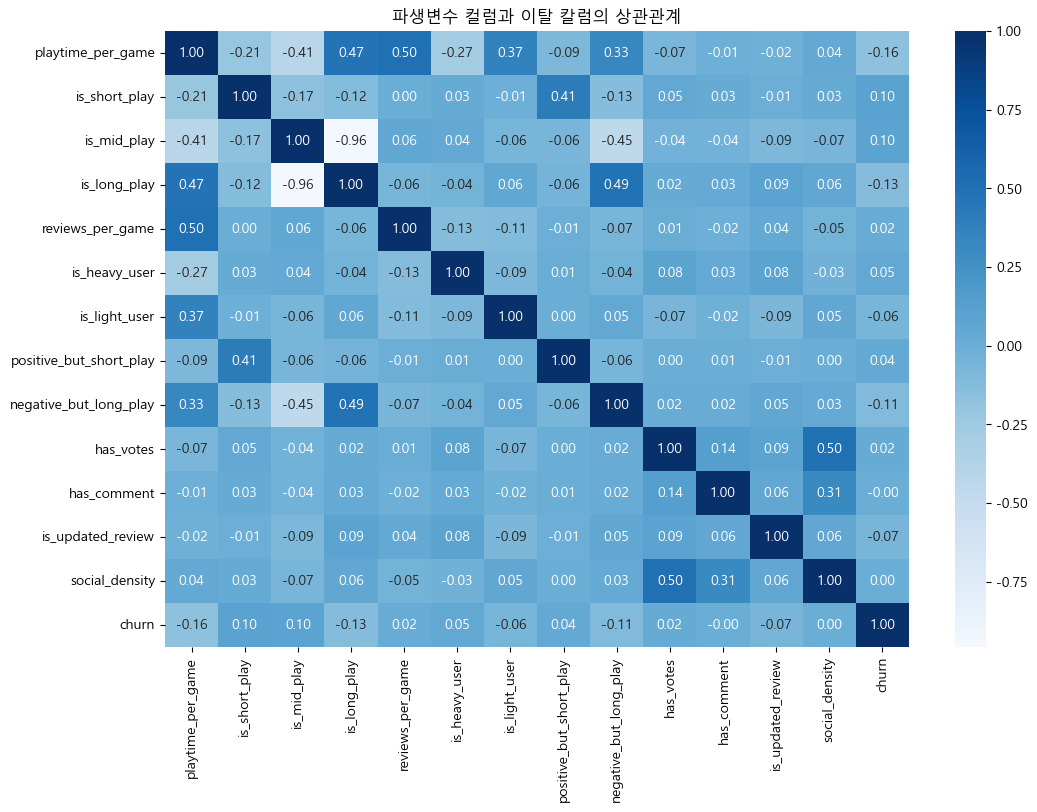

In [ ]:
# heatmap에 churn도 포함
derived_cols = derived_cols + ['churn']

# 상관계수 계산
corr = df_model[derived_cols].corr()

# 시각화
plt.figure(figsize=(12,8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="Blues",   # 남색 계열
    center=0
)
plt.title("파생변수 컬럼과 이탈 칼럼의 상관관계")
plt.show()

- 리뷰 감정 × 플레이어 행동 결합 시각화

C:\Users\Playdata\AppData\Local\Temp\ipykernel_9200\3941402924.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars1 = sns.barplot(
C:\Users\Playdata\AppData\Local\Temp\ipykernel_9200\3941402924.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars2 = sns.barplot(


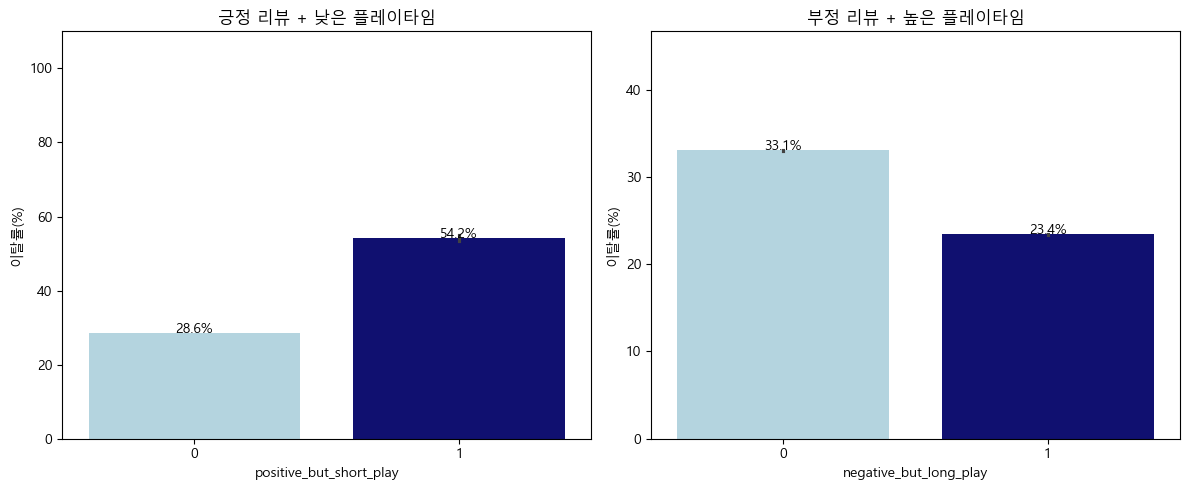

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Positive Review but Short Play
bars1 = sns.barplot(
    data=df_model,
    x='positive_but_short_play',
    y=df_model['churn']* 100,
    palette=["lightblue", "navy"],  # 0=연한 파랑, 1=진한 네이비
    ax=axes[0]
)
axes[0].set_title('긍정 리뷰 + 낮은 플레이타임')
axes[0].set_ylabel("이탈률(%)")
axes[0].set_ylim(0, 110)

# 바 위 숫자 라벨 (%)
for bar in bars1.patches:
    height = bar.get_height()
    axes[0].text(
        bar.get_x() + bar.get_width()/2,
        height + 0.01,
        f"{height:.1f}%",
        ha='center'
    )

# Negative Review but Long Play
bars2 = sns.barplot(
    data=df_model,
    x='negative_but_long_play',
    y=df_model['churn']* 100,
    palette=["lightblue", "navy"],  # 0=연한 파랑, 1=진한 네이비
    ax=axes[1]
)
axes[1].set_title('부정 리뷰 + 높은 플레이타임')
axes[1].set_ylabel("이탈률(%)")
axes[1].set_ylim(0, 110)

# 바 위 숫자 라벨 (%)
for bar in bars2.patches:
    height = bar.get_height()
    axes[1].text(
        bar.get_x() + bar.get_width()/2,
        height + 0.01,
        f"{height:.1f}%",
        ha='center'
    )

plt.ylim(0, style_churn['churn'].max() * 1.15)  # 라벨 잘리기 방지

plt.tight_layout()
plt.show()

# 3. 데이터 전처리

### 3.1. 수치형 변수 제외 칼럼 인코딩  

- language 칼럼과 game_style 칼럼 정제 (세부 칼럼들로 추가 생성)

In [67]:
# df_model[['language', 'voted_up', 'steam_purchase', 'received_for_free', 'written_during_early_access', 'primarily_steam_deck', 'game_style']]

# 'language' ('english', 'koreana', ...), 'game_style' ('online','video','story') 인코딩 (True/False)
# df_model['language'].value_counts()     # 카테고리가 많아 상위 10개 미만 값들은 others로 통합.

# 상위 10개 언어 추출
top_n = 10
top_langs = df_model['language'].value_counts().head(top_n).index

# 상위 10개만 유지, 나머지는 other
df_model['language'] = df_model['language'].where(
    df_model['language'].isin(top_langs),
    'other'
)

df_model = pd.get_dummies(                  #get_dummies 는 columns 를 자동 제거
    df_model,
    columns=['language', 'game_style'],
    drop_first=True
)

In [68]:
# 생성된 컬럼 확인
print([col for col in df_model.columns if col.startswith('language_')])
print([col for col in df_model.columns if col.startswith('game_style_')]) # game_style_online은 둘다 ('game_style_story', 'game_style_video') 0 인 것

['language_english', 'language_french', 'language_german', 'language_koreana', 'language_other', 'language_polish', 'language_russian', 'language_schinese', 'language_spanish', 'language_turkish']
['game_style_story', 'game_style_video']


- 원핫인코딩 (True 1, False 0)

In [69]:
# df_model[['voted_up', 'steam_purchase', 'received_for_free', 'written_during_early_access', 'primarily_steam_deck']]
# 인코딩된 언어 칼럼들: ['language_english', 'language_french', 'language_german','language_koreana','language_other','language_polish','language_russian','language_schinese','language_spanish','language_turkish']
# 인코딩된 게임 스타일 칼럼들: ['game_style_story', 'game_style_video']

bool_cols = ['voted_up', 'steam_purchase', 'received_for_free', 'written_during_early_access', 'primarily_steam_deck',
            'language_english', 'language_french', 'language_german','language_koreana','language_other','language_polish','language_russian','language_schinese','language_spanish','language_turkish',
            'game_style_story', 'game_style_video'
            ]

for col in bool_cols:
    df_model[col] = df_model[col].astype(int)

# df_model['voted_up'].value_counts()
# df_model['language_english'].value_counts()
# df_model['game_style_story'].value_counts()

### 3.2. 데이터 분리 (타겟 변수와 피처 변수)

- 학습용 피처 목록 확정 + top50 appid 잡기

In [70]:
TARGET = "churn"

#  최종 확정한 피처
FEATURES = [
    "voted_up",
    "weighted_vote_score",
    "steam_purchase",
    "received_for_free",
    "written_during_early_access",
    "primarily_steam_deck",

    # 원핫된 language/game_style 컬럼들 (만든 컬럼명 그대로)
    "language_english", "language_french", "language_german", "language_koreana",
    "language_other", "language_polish", "language_russian", "language_schinese",
    "language_spanish", "language_turkish",
    "game_style_story", "game_style_video",

    # 파생 피처들
    "playtime_per_game",
    "is_short_play", "is_mid_play", "is_long_play",
    "reviews_per_game",
    "is_heavy_user", 'is_light_user',
    "positive_but_short_play",
    "negative_but_long_play",
    "has_votes",
    "has_comment",
    "is_updated_review",
    "social_density",
]

FEATURES_RAW = FEATURES.copy()
# 혹시 누락/오타로 없는 컬럼이 있으면 자동 제외(코드 안깨지게)
FEATURES = [c for c in FEATURES if c in df_model.columns]
# 누락된게 있으면 누락된 컬럼 로그 남기는 구문
missing = [c for c in FEATURES_RAW if c not in df_model.columns]
print("missing_features:", missing)


# top50 appid (리뷰 많은 순)
top_appids = (
    df_model.groupby("appid")
            .size()
            .sort_values(ascending=False)
            .head(50)
            .index.tolist()
)

print("n_features:", len(FEATURES))
print("top_appids(50) sample:", top_appids[:5])

missing_features: []
n_features: 31
top_appids(50) sample: [3241660, 2807960, 730, 1808500, 1030300]


# 4. 모델 학습 및 평가

### 4.1. 모델 선정 
- Logistic Regression, Random Forest, Hist GB

- 게임별 학습 루프 (로지스틱=스케일 / 트리=노스케일) + 결과 테이블

In [73]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

# 모델: 로지스틱(스케일링) / 트리2개(스케일링 없음)
models = {
    "Logistic": Pipeline([  # 전처리 + 모델 한 덩어리로 묶어주는 구문
        ("scaler", StandardScaler()),   # 로지스틱은 거리/크기 영향이 커서 스케일링 필수
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))
    ]),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1, class_weight="balanced"
    ),
    "HistGB": HistGradientBoostingClassifier(random_state=RANDOM_STATE)
}

def eval_metrics(y_true, y_pred):
    return {
        "acc": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "pos_rate": float(np.mean(y_pred == 1))
    }

results = []
# result_list = []

for appid in top_appids:
    gdf = df_model[df_model["appid"] == appid]

    # 타깃이 한쪽만 있으면 학습 불가
    if gdf[TARGET].nunique() < 2:
        continue

    X = gdf[FEATURES]
    y = gdf[TARGET].astype(int)

    # stratify split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )

    for name, model in models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)

        m = eval_metrics(y_test, pred)
        results.append({
            "appid": int(appid),
            "n_rows": int(len(gdf)),
            "churn_rate": float(y.mean()),
            "model": name,
            **m # acc/precision/recall/f1/pos_rate 펼쳐서 저장
        })

results_df = pd.DataFrame(results).sort_values(["f1", "recall"], ascending=False).reset_index(drop=True)

print("done. rows:", len(results_df))

best_per_appid = (results_df
                  .sort_values(["appid", "f1", "recall"], ascending=[True, False, False])
                  .groupby("appid")
                  .head(1)
                  .reset_index(drop=True))

display(best_per_appid)



done. rows: 150


,appid,n_rows,churn_rate,model,acc,precision,recall,f1,pos_rate
0,440,44206,0.319821,Logistic,0.661276,0.478617,0.660891,0.555176,0.441642
1,570,204029,0.193169,HistGB,0.862716,0.744321,0.440624,0.553554,0.114346
2,730,272473,0.184881,Logistic,0.595229,0.245465,0.573499,0.343785,0.431948
3,108600,83054,0.287054,Logistic,0.622118,0.389902,0.560403,0.459857,0.412558
4,227300,92151,0.227171,Logistic,0.608214,0.302165,0.553380,0.390890,0.416038
5,230410,48982,0.204279,Logistic,0.699908,0.366277,0.642679,0.466618,0.358375
6,236390,45835,0.309480,Logistic,0.656158,0.459791,0.634826,0.533314,0.427294
7,294100,30831,0.233110,Logistic,0.599643,0.304216,0.557024,0.393515,0.426950
8,394360,41971,0.188463,Logistic,0.680762,0.322674,0.631479,0.427106,0.368791
9,413150,81315,0.336420,Logistic,0.590420,0.417476,0.550174,0.474726,0.443338


### 4.2. 모델 추가
- LightGBM

In [75]:
os.makedirs("model", exist_ok=True)
RANDOM_STATE = 42
TEST_SIZE = 0.2

- 모델 딕셔너리

In [76]:
models = {
    "Logistic": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))
    ]),
    "LightGBM": LGBMClassifier(
        n_estimators=10,
        learning_rate=0.05,
        num_leaves=63,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        class_weight="balanced",
        verbose=-1,
    ),
    "HistGB": HistGradientBoostingClassifier(random_state=RANDOM_STATE)
}


- 유틸 함수들

In [77]:
# 모델이 예측한 양성 확률만 뽑음
def get_proba(model, X):
    return model.predict_proba(X)[:, 1]

def eval_metrics(y_true, y_pred, y_proba):
    return {
        "acc": accuracy_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_proba),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "pos_rate": float(np.mean(y_pred == 1))
    }


- 결과 리스트 + 진행바 준비(tqdm)

In [78]:
results = []    # 전체 appid 모델 결과를 계속 쌓는 리스트
result_list = []    # 현재 appid에서만 3개 모델결과 + 모델객체를 모아서 best1개만 뽑기위한 리스트

pbar = tqdm(top_appids, desc="Games", unit="game")  # 바깥 진행바 1개만


Games:   0%|          | 0/50 [00:00<?, ?game/s]

### 4.3. 모델 학습/평가 및 저장

- 메인 루프(학습 + 평가 + 모델 저장)

In [79]:
for appid in pbar:
    gdf = df_model[df_model["appid"] == appid]

    if gdf[TARGET].nunique() < 2:
        continue

    X = gdf[FEATURES]
    y = gdf[TARGET].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )

    for name, model in models.items():
        # set_postfix_str은 tqdm 진행바 오른쪽에 추가 텍스트를 붙여주는 기능
        pbar.set_postfix_str(f"appid={appid} | model={name}", refresh=True)
        model.fit(X_train, y_train)

        # 확률 예측 -> 임계값 0.5로 라벨화
        # get_proba 함수는 각 샘플에 대해 class 0 혹은 1의 확률을 줌. 그 중 1의 확률만 뽑는것
        # tr은 train의 각 행이 churn = 1일 확률 배열
        tr_proba = get_proba(model, X_train)
        tr_pred  = (tr_proba >= 0.5).astype(int)

        # te는 test 각 행이 churn = 1일 확률 배열
        te_proba = get_proba(model, X_test)
        te_pred  = (te_proba >= 0.5).astype(int)

        # eval_metrics 성능 지표 함수
        tr_m = eval_metrics(y_train, tr_pred, tr_proba)
        te_m = eval_metrics(y_test,  te_pred, te_proba)

        # pd.DataFrame으로 만들기 쉽게 하려고 한 번의 결과를 한 행으로 표현
        row = {
            "appid": int(appid),
            "n_rows": int(len(gdf)),
            "churn_rate": float(y.mean()),
            "model": name,

            "train_acc": tr_m["acc"],   # eval_metrics가 반환한 dict
            "train_roc_auc": tr_m["roc_auc"],
            "train_precision": tr_m["precision"],
            "train_recall": tr_m["recall"],
            "train_f1": tr_m["f1"],
            "train_pos_rate": tr_m["pos_rate"],

            "test_acc": te_m["acc"],
            "test_roc_auc": te_m["roc_auc"],
            "test_precision": te_m["precision"],
            "test_recall": te_m["recall"],
            "test_f1": te_m["f1"],
            "test_pos_rate": te_m["pos_rate"],
        }

        results.append(row)
        # **row는 row 내용 그대로 복사해서 넣기
        result_list.append({**row, "model_obj": model})

    # appid별 최고 모델 1개 저장
    result_list_df = (
        pd.DataFrame(result_list)
          .sort_values(["test_f1", "test_recall"], ascending=False)
          .head(1)
    )

    best_row = result_list_df.iloc[0]
    best_appid = int(best_row["appid"])
    best_model = best_row["model_obj"]

    path = f"model/model_{best_appid}.pkl"
    joblib.dump(best_model, path)

    result_list = []

pbar.set_postfix_str("")


Games: 100%|██████████| 50/50 [01:41<00:00,  2.03s/game, appid=1222670 | model=HistGB]  


- 전체 결과 DataFrame 만들기 + 출력
- 전체 결과 중 점수 높은 50개 행을 보여주는 것

In [80]:
results_df = (
    pd.DataFrame(results)
      .sort_values(["test_f1", "test_recall"], ascending=False)
      .reset_index(drop=True)
)

print("done. rows:", len(results_df))
display(results_df.head(50))


done. rows: 150


,appid,n_rows,churn_rate,model,train_acc,train_roc_auc,train_precision,train_recall,train_f1,train_pos_rate,test_acc,test_roc_auc,test_precision,test_recall,test_f1,test_pos_rate
0,3527290,31721,0.699001,HistGB,0.718356,0.695883,0.724795,0.962566,0.826928,0.928318,0.703388,0.649611,0.716981,0.951071,0.817600,0.927187
1,1222140,64366,0.648681,HistGB,0.665715,0.646797,0.668065,0.963296,0.788966,0.935349,0.658770,0.613824,0.663987,0.959526,0.784857,0.937393
2,2592160,150629,0.594527,HistGB,0.696323,0.716970,0.699781,0.856788,0.770366,0.727915,0.690234,0.707161,0.696199,0.849813,0.765374,0.725719
3,2592160,150629,0.594527,LightGBM,0.686439,0.707619,0.711276,0.795497,0.751033,0.664921,0.680409,0.700068,0.707417,0.788622,0.745816,0.662783
4,3527290,31721,0.699001,Logistic,0.641236,0.649257,0.769577,0.694780,0.730268,0.631069,0.641135,0.643460,0.766026,0.700564,0.731834,0.639243
5,2001120,109621,0.562949,HistGB,0.671775,0.728515,0.688236,0.762235,0.723348,0.623472,0.660570,0.712662,0.678491,0.754679,0.714560,0.626180
6,3527290,31721,0.699001,LightGBM,0.655225,0.688845,0.790624,0.689311,0.736500,0.609434,0.626635,0.642902,0.767478,0.668320,0.714475,0.608668
7,2592160,150629,0.594527,Logistic,0.612201,0.617077,0.655560,0.732671,0.691974,0.664456,0.613855,0.618365,0.657312,0.732287,0.692777,0.662351
8,2001120,109621,0.562949,LightGBM,0.652538,0.714132,0.715184,0.636100,0.673328,0.500696,0.648301,0.707559,0.711352,0.631532,0.669070,0.499795
9,1903340,119542,0.546661,HistGB,0.614652,0.657227,0.623874,0.743090,0.678283,0.651125,0.600569,0.636699,0.613607,0.727314,0.665640,0.647957


- 각 appid당 최고 1개만(중복없이) 출력

In [81]:
best_per_appid = (
    pd.DataFrame(results)
      .sort_values(["appid", "test_f1", "test_recall"], ascending=[True, False, False])
      .groupby("appid", as_index=False)
      .head(1)
      .sort_values(["test_f1", "test_recall"], ascending=False)
      .reset_index(drop=True)
)

print("unique appids:", best_per_appid["appid"].nunique())
display(best_per_appid.head(50))


unique appids: 50


,appid,n_rows,churn_rate,model,train_acc,train_roc_auc,train_precision,train_recall,train_f1,train_pos_rate,test_acc,test_roc_auc,test_precision,test_recall,test_f1,test_pos_rate
0,3527290,31721,0.699001,HistGB,0.718356,0.695883,0.724795,0.962566,0.826928,0.928318,0.703388,0.649611,0.716981,0.951071,0.817600,0.927187
1,1222140,64366,0.648681,HistGB,0.665715,0.646797,0.668065,0.963296,0.788966,0.935349,0.658770,0.613824,0.663987,0.959526,0.784857,0.937393
2,2592160,150629,0.594527,HistGB,0.696323,0.716970,0.699781,0.856788,0.770366,0.727915,0.690234,0.707161,0.696199,0.849813,0.765374,0.725719
3,2001120,109621,0.562949,HistGB,0.671775,0.728515,0.688236,0.762235,0.723348,0.623472,0.660570,0.712662,0.678491,0.754679,0.714560,0.626180
4,1903340,119542,0.546661,HistGB,0.614652,0.657227,0.623874,0.743090,0.678283,0.651125,0.600569,0.636699,0.613607,0.727314,0.665640,0.647957
5,1145350,51398,0.410814,Logistic,0.619729,0.715792,0.523634,0.823704,0.640254,0.646238,0.623930,0.709473,0.527264,0.817428,0.641040,0.636868
6,3564740,93627,0.323475,LightGBM,0.724396,0.787806,0.559454,0.696356,0.620442,0.402638,0.720068,0.783015,0.554239,0.687469,0.613707,0.401207
7,3167020,96654,0.487222,LightGBM,0.650996,0.709129,0.671139,0.556272,0.608331,0.403838,0.639801,0.693099,0.655557,0.549267,0.597724,0.408204
8,3932890,41232,0.303817,LightGBM,0.715052,0.799283,0.521633,0.748329,0.614748,0.435834,0.696132,0.774576,0.500000,0.719872,0.590121,0.437492
9,990080,57746,0.407145,LightGBM,0.657676,0.696691,0.575507,0.606657,0.590671,0.429171,0.642424,0.677114,0.556453,0.600468,0.577623,0.439394


- 게임별 최고 모델 출력

In [82]:
best_by_game = (
    results_df.sort_values(["appid", "test_f1", "test_recall"], ascending=[True, False, False])
              .groupby("appid", as_index=False)
              .head(1)
              .sort_values("test_f1", ascending=False)
              .reset_index(drop=True)
)

display(best_by_game.head(50))


,appid,n_rows,churn_rate,model,train_acc,train_roc_auc,train_precision,train_recall,train_f1,train_pos_rate,test_acc,test_roc_auc,test_precision,test_recall,test_f1,test_pos_rate
0,3527290,31721,0.699001,HistGB,0.718356,0.695883,0.724795,0.962566,0.826928,0.928318,0.703388,0.649611,0.716981,0.951071,0.817600,0.927187
1,1222140,64366,0.648681,HistGB,0.665715,0.646797,0.668065,0.963296,0.788966,0.935349,0.658770,0.613824,0.663987,0.959526,0.784857,0.937393
2,2592160,150629,0.594527,HistGB,0.696323,0.716970,0.699781,0.856788,0.770366,0.727915,0.690234,0.707161,0.696199,0.849813,0.765374,0.725719
3,2001120,109621,0.562949,HistGB,0.671775,0.728515,0.688236,0.762235,0.723348,0.623472,0.660570,0.712662,0.678491,0.754679,0.714560,0.626180
4,1903340,119542,0.546661,HistGB,0.614652,0.657227,0.623874,0.743090,0.678283,0.651125,0.600569,0.636699,0.613607,0.727314,0.665640,0.647957
5,1145350,51398,0.410814,Logistic,0.619729,0.715792,0.523634,0.823704,0.640254,0.646238,0.623930,0.709473,0.527264,0.817428,0.641040,0.636868
6,3564740,93627,0.323475,LightGBM,0.724396,0.787806,0.559454,0.696356,0.620442,0.402638,0.720068,0.783015,0.554239,0.687469,0.613707,0.401207
7,3167020,96654,0.487222,LightGBM,0.650996,0.709129,0.671139,0.556272,0.608331,0.403838,0.639801,0.693099,0.655557,0.549267,0.597724,0.408204
8,3932890,41232,0.303817,LightGBM,0.715052,0.799283,0.521633,0.748329,0.614748,0.435834,0.696132,0.774576,0.500000,0.719872,0.590121,0.437492
9,990080,57746,0.407145,LightGBM,0.657676,0.696691,0.575507,0.606657,0.590671,0.429171,0.642424,0.677114,0.556453,0.600468,0.577623,0.439394


In [83]:
best_df = best_by_game.copy()

F1_LOW = 0.50   # test_f1이 0.5보다 낮은 appid들을 튜닝 후보 선정
POS_GAP = 0.25  # test_pos_rate - churn_rate으로 0.25보다 크면 과예측으로 보고 튜닝 후보
POS_MULT = 1.8  # test_pos_rate / churn_rate가 1.8배 이상이면 실제보다 1을 1.8배 넘게 찍는다로 보고 튜닝 후보

#  test 기준으로 pos 관련 계산 (원래 pos_rate 대신 test_pos_rate 사용)
best_df["pos_gap"]  = best_df["test_pos_rate"] - best_df["churn_rate"] # +면 과탐/과예측 경향
best_df["pos_mult"] = best_df["test_pos_rate"] / (best_df["churn_rate"] + 1e-12) # -면 과소예측 경향

need_tune = best_df[    # 하나라도 걸리면 튜닝 대상
    (best_df["test_f1"] < F1_LOW) |
    (best_df["pos_gap"] > POS_GAP) |
    ((best_df["churn_rate"] < 0.35) & (best_df["pos_mult"] > POS_MULT))
].copy()

MAX_TUNE_GAMES = 20 # 튜닝은 최대 20개만 제한
need_tune = need_tune.sort_values("test_f1", ascending=True).head(MAX_TUNE_GAMES)   # test_f1 낮은 순으로 정렬 후 가장 성능 안좋은 것부터 우선으로 처리

# 튜닝할 appid 리스트 뽑기왕
tune_appids = need_tune["appid"].astype(int).tolist()

print("튜닝 대상 appid 개수:", len(tune_appids))

display_cols = [
    "appid","n_rows","churn_rate","model",
    #  train
    "train_acc","train_precision","train_recall","train_f1","train_pos_rate",
    # test
    "test_acc","test_precision","test_recall","test_f1","test_pos_rate",
    #  drift/overpredict 체크
    "pos_gap","pos_mult"
]

# 튜닝할 대상 게임들에 대해 train, test, 예측 1 비율 과예측 여부(pos_gap/pos_mult) 출력
display(need_tune[display_cols])

튜닝 대상 appid 개수: 20


,appid,n_rows,churn_rate,model,train_acc,train_precision,train_recall,train_f1,train_pos_rate,test_acc,test_precision,test_recall,test_f1,test_pos_rate,pos_gap,pos_mult
49,1973530,43061,0.084206,LightGBM,0.774472,0.224910,0.685970,0.338752,0.256851,0.778474,0.222170,0.652414,0.331465,0.247184,0.162978,2.935469
48,730,272473,0.184881,LightGBM,0.631408,0.260471,0.540273,0.351486,0.383484,0.628700,0.256204,0.529826,0.345390,0.382329,0.197448,2.067975
47,553850,148012,0.139239,LightGBM,0.680860,0.248382,0.637715,0.357516,0.357490,0.674290,0.239917,0.617661,0.345595,0.358477,0.219238,2.574551
46,3405690,36162,0.174050,LightGBM,0.640326,0.277842,0.666931,0.392267,0.417781,0.629061,0.264082,0.633042,0.372691,0.417254,0.243204,2.397323
45,1808500,252277,0.186660,LightGBM,0.686346,0.304554,0.530075,0.386846,0.324882,0.684359,0.300417,0.520068,0.380841,0.323133,0.136473,1.731133
44,1551360,53036,0.217230,LightGBM,0.689804,0.349074,0.494846,0.409370,0.307957,0.679204,0.330975,0.467014,0.387399,0.306467,0.089237,1.410795
43,227300,92151,0.227171,Logistic,0.605629,0.301142,0.557294,0.391001,0.420402,0.608214,0.302165,0.553380,0.390890,0.416038,0.188868,1.831391
42,3240220,138626,0.219338,LightGBM,0.654878,0.326871,0.541336,0.407615,0.363255,0.646613,0.314317,0.517349,0.391050,0.360997,0.141659,1.645845
41,294100,30831,0.233110,Logistic,0.599984,0.307455,0.571752,0.399878,0.433466,0.599643,0.304216,0.557024,0.393515,0.426950,0.193840,1.831542
40,1245620,108874,0.265821,Logistic,0.620455,0.347779,0.488706,0.406371,0.373540,0.623146,0.352705,0.500173,0.413690,0.376946,0.111125,1.418044


# 5. 하이퍼파라미터 튜닝 및 재학습

### 5.1. GridSearchCV

- 그리드 튜닝 + best threshold 뽑기

- 그리드/튜닝은 2단계 튜닝 파이프라인
  - 로지스틱과 히스토는 튜닝해도 효과가 크지 않아서 제외(학습시간 너무 오래걸림)
  - 튜닝효과가 큰 lightgbm만 하이퍼파라미터를 RandomizedSearchCV로 탐색, 그 best 모델에 대해 threshold도 최적화

### 5.2. RandomizedSearchCV

In [84]:
os.makedirs("model", exist_ok=True)

RANDOM_STATE = 42
TEST_SIZE = 0.20        
VAL_SIZE_IN_TRAIN = 0.20 # test 20을 제외한 train의 80중 20%를 가져와서 16%
TARGET = "churn"

# 2시간 목표 세팅
CV_SPLITS = 3   # 하이퍼파라미터 탐색할 때 3-fold CV
# randomizedsearch가 모델 비교할 때 auc 기준으로 최적 조합 고름
# AUC 는 임계값(0.5같은 고정값)에 덜 민감해서 모델의 순수 분리능력을 보기에 좋다고 판단.
SEARCH_SCORING = "roc_auc"  
LGBM_N_ITER = 30 # 파라미터 조합 30번만 샘플링(시간제한으로 인해 30이상하면 너무 오래걸려요)
THR_GRID = np.round(np.arange(0.10, 0.91, 0.02), 2) # 임계값 튜닝 후보들 및 간격

print("FEATURES 개수:", len(FEATURES))
print("튜닝 대상 appid 수:", len(tune_appids))


FEATURES 개수: 31
튜닝 대상 appid 수: 20


- 유틸 함수들(proba/metrics/threshold)

In [85]:
# predict_prob 결과에서 churn 1만 뽑음
def get_proba(clf, X):
    return clf.predict_proba(X)[:, 1]

# 라벨 예측(y_pred)만 넣어서 기본 지표 계산
def metrics(y_true, y_pred):
    return {
        "acc": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "pos_rate": float(np.mean(y_pred == 1))
    }
# val데이터에서 임계값 여러개 시험 후 F1이 최대가 되는 임계값 반환하는 함수
def best_threshold_by_f1(y_true, proba, thr_grid=THR_GRID):
    best_f1, best_thr = -1.0, 0.5
    for thr in thr_grid:
        pred = (proba >= thr).astype(int)
        f1 = f1_score(y_true, pred, zero_division=0)
        if f1 > best_f1:
            best_f1, best_thr = f1, float(thr)
    return float(best_thr)


- 고정 후보 모델 (튜닝 X)

In [86]:
fixed_candidates = [
    ("Logistic",
     Pipeline([
         ("scaler", StandardScaler()),
         ("clf", LogisticRegression(
             max_iter=4000,
             class_weight="balanced",
             random_state=RANDOM_STATE
         ))
     ])),
    ("HistGB",
     Pipeline([
         ("clf", HistGradientBoostingClassifier(
             random_state=RANDOM_STATE,
             learning_rate=0.05,
             max_leaf_nodes=63,
             min_samples_leaf=50,
             max_iter=400
         ))
     ])),
]


- LightGBM 튜닝 파이프라인 + 탐색공간 + CV

In [87]:
lgbm_pipe = Pipeline([  # pipeline으로 감싼 이유는 randomizedsearchCV에서 파라미터 이름을 clf_ 형태로 사용하기 우함.
    ("clf", LGBMClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

lgbm_space = {
    "clf__n_estimators": [500, 800, 1200],      # 트리(부스팅) 개수 = 학습 라운드 수
    "clf__learning_rate": [0.02, 0.05, 0.08],   # 학습률
    "clf__num_leaves": [31, 63, 127, 255],      # 트리의 복잡도/표현력 -> num_leaves가 더 크면 더 복잡한 분할 가능 하지만 과적합 위험 / max_depth와 트리 복잡도 결정
    "clf__max_depth": [-1, 8, 12],              # 트리 최대 깊이 제한
    "clf__min_child_samples": [20, 50, 100],    # 값이 크면 세밀한 분할을 막아 과적합 방지
    "clf__subsample": [0.8, 0.9, 1.0],          # 생 샘플링 비율
    "clf__colsample_bytree": [0.8, 0.9, 1.0],   # 1.0이면 전부 사용 / 낮추면 랜덤성 증가해 과적합을 줄이는데 도움
    "clf__reg_alpha": [0.0, 0.1, 0.5],          # 0이면 사용안함 / 값을 키우면 일부 가중치를 0에 가깝게 만들어 모델을 더 단순하게 하여 과적합 완화
    "clf__reg_lambda": [0.0, 1.0, 3.0],         # 0이면 사용안함 / 값을 키우면 가중치가 너무 커지는 것을 억제 -> 과적합 완화/안정성 증가
}

# lightgbm 탐색에서 fold를 어떻게 나눌지 정의.
cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)


- 튜닝 루프(본문) - appid별로 best 찾고 저장

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
tuned_rows = [] # 각 appid에서 최종 best_model 1개만 모아둘 리스트

for appid in tqdm(tune_appids, desc="Tuning games"):
    gdf = df_model[df_model["appid"] == appid].copy()
    gdf = gdf.replace([np.inf, -np.inf], 0)  # inf/-inf를 0으로 바꿈 -> lightgbm 학습에서 inf가 있으면 터질 수 있어서 방지

    if gdf[TARGET].nunique() < 2:
        continue

    X = gdf[FEATURES]
    y = gdf[TARGET].astype(int)

    # 3 way split (학습/테스트/검증)
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    # train_full 80%을 다시 train/val로 나눔
    # val은 임계값 선택, 모델 선택 등에 사용
    # # 이 구조 덕분에 test로 모델 선정 하지 않아 더 탄탄 
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full,
        test_size=VAL_SIZE_IN_TRAIN, random_state=RANDOM_STATE, stratify=y_train_full
    )

    best_game = None

    # 고정 모델 평가
    for name, model in fixed_candidates:
        model.fit(X_train, y_train)

        # val 확률 구한 후 val F1이 최대가 되는 threshold를 찾음
        val_proba = get_proba(model, X_val)
        best_thr = best_threshold_by_f1(y_val, val_proba)
        # 찾은 threshold로 val 예측 라벨 만들고 val_f1 계산
        # 아까 말했듯이 val_f1이 모델의 선택 기준 점수가 됨
        val_pred = (val_proba >= best_thr).astype(int)
        val_f1 = f1_score(y_val, val_pred, zero_division=0)

        # threshold는 val에서 정했으니 그 임계값으로 train_full, test 성능 계산해 과적합/일반화 비교
        tr_proba = get_proba(model, X_train_full)
        te_proba = get_proba(model, X_test)

        tr_pred = (tr_proba >= best_thr).astype(int)
        te_pred = (te_proba >= best_thr).astype(int)

        # train/test 지표 계산
        tr_m = metrics(y_train_full, tr_pred)
        te_m = metrics(y_test, te_pred)

        row = {
            "appid": int(appid),
            "n_rows": int(len(gdf)),
            "churn_rate": float(y.mean()),
            "model": name,
            "best_thr": float(best_thr),
            "val_f1": float(val_f1),
            "cv_best_score": np.nan,
            "best_params": None,
            "train_acc": tr_m["acc"], "train_precision": tr_m["precision"],
            "train_recall": tr_m["recall"], "train_f1": tr_m["f1"], "train_pos_rate": tr_m["pos_rate"],
            "test_acc": te_m["acc"], "test_precision": te_m["precision"],
            "test_recall": te_m["recall"], "test_f1": te_m["f1"], "test_pos_rate": te_m["pos_rate"],
            "model_obj": model
        }

        # 현재 appid의 best_game 갱신
        key = (row["val_f1"], row["test_f1"])
        if (best_game is None) or (key > (best_game["val_f1"], best_game["test_f1"])):
            best_game = row

    # LightGBM RandomizedSearch
    search = RandomizedSearchCV(
        lgbm_pipe,
        lgbm_space,
        n_iter=LGBM_N_ITER,
        scoring=SEARCH_SCORING, # 각 조합의 CV 점수를 AUC로 평가
        cv=cv,                  # 위에서 만들었던 3-fold
        n_jobs=1,  # 중첩 병렬 방지
        random_state=RANDOM_STATE,
        refit=True              # 가장 좋은 조합으로 전체 X_train에 다시 fit한 best_estimator_ 생성
    )
    # 탐색 실행 -> best 모델 획득
    search.fit(X_train, y_train)
    best_est = search.best_estimator_

    # best 모델”의 확률로 val에서 best_thr 찾고 val_f1 계산
    val_proba = get_proba(best_est, X_val)
    best_thr = best_threshold_by_f1(y_val, val_proba)

    val_pred = (val_proba >= best_thr).astype(int)
    val_f1 = f1_score(y_val, val_pred, zero_division=0)

    # val에서 고른 threshold를 그대로 적용
    tr_proba = get_proba(best_est, X_train_full)
    te_proba = get_proba(best_est, X_test)

    tr_pred = (tr_proba >= best_thr).astype(int)
    te_pred = (te_proba >= best_thr).astype(int)

    tr_m = metrics(y_train_full, tr_pred)
    te_m = metrics(y_test, te_pred)

    row = {
        "appid": int(appid),
        "n_rows": int(len(gdf)),
        "churn_rate": float(y.mean()),
        "model": "LightGBM",
        "best_thr": float(best_thr),
        "val_f1": float(val_f1),
        "cv_best_score": float(search.best_score_),
        "best_params": search.best_params_,
        "train_acc": tr_m["acc"], "train_precision": tr_m["precision"],
        "train_recall": tr_m["recall"], "train_f1": tr_m["f1"], "train_pos_rate": tr_m["pos_rate"],
        "test_acc": te_m["acc"], "test_precision": te_m["precision"],
        "test_recall": te_m["recall"], "test_f1": te_m["f1"], "test_pos_rate": te_m["pos_rate"],
        "model_obj": search
    }

    # best 선택 기준: val_f1 우선 -> 동점이면 cv_best_score
    key = (row["val_f1"], row["cv_best_score"])
    if (best_game is None) or (key > (best_game["val_f1"], best_game.get("cv_best_score", -1))):
        best_game = row

    # appid별 best 저장
    if best_game is not None:
        tuned_rows.append(best_game)
        # 만약 lightgbm이 베스트 모델로 들어왔다면 search 객체에서 진짜 모델은 best_estimator_이므로 그걸 꺼냄.
        # 로지스틱, 히스토면 model_obj 자체가 이미 모델이니까 그대로
        appid_int = best_game["appid"]
        if best_game["model"] == "LightGBM":
            best_model = best_game["model_obj"].best_estimator_
            best_params = best_game["best_params"]
        else:
            best_model = best_game["model_obj"]
            best_params = None
        # 스트림릿에서 로드에서 예측할 때,
        # payload["model"]로 predict_proba 실행  후 payload["best_thr"]로 0/1 라벨화
        payload = {
            "model": best_model,
            "best_thr": float(best_game["best_thr"]),
            "model_name": best_game["model"],
            "best_params": best_params
        }

        joblib.dump(payload, f"model/model_{appid_int}.pkl")


Tuning games:   5%|▌         | 1/20 [03:01<57:26, 181.38s/it]

- 결과 DataFrame 만들기

In [37]:
# appid별 best_game만 모은 tuned_rows는 dataframe으로 반환
# test_f1 높은 순으로 정렬 후 상위 30개 출력
tuned_df = (
    pd.DataFrame(tuned_rows)
      .sort_values("test_f1", ascending=False)
      .reset_index(drop=True)
)

print("튜닝 완료 게임 수:", len(tuned_df))


튜닝 완료 게임 수: 20


- 상위 결과 확인

In [38]:
display(tuned_df.head(30))


,appid,n_rows,churn_rate,model,best_thr,val_f1,cv_best_score,best_params,train_acc,train_precision,train_recall,train_f1,train_pos_rate,test_acc,test_precision,test_recall,test_f1,test_pos_rate,model_obj
0,1086940,105187,0.299067,LightGBM,0.44,0.482763,0.636268,"{'clf__subsample': 1.0, 'clf__reg_lambda': 1.0...",0.540993,0.369267,0.755305,0.496027,0.611713,0.529898,0.361017,0.742689,0.485860,0.615268,RandomizedSearchCV(cv=StratifiedKFold(n_splits...
1,526870,40282,0.309940,HistGB,0.24,0.487895,NaN,None,0.408037,0.336476,0.936123,0.495023,0.862312,0.398163,0.330156,0.915499,0.485299,0.859377,(HistGradientBoostingClassifier(learning_rate=...
2,230410,48982,0.204279,HistGB,0.24,0.474001,NaN,None,0.767768,0.446932,0.576015,0.503329,0.263290,0.759824,0.429712,0.537731,0.477691,0.255588,(HistGradientBoostingClassifier(learning_rate=...
3,108600,83054,0.287054,HistGB,0.22,0.470928,NaN,None,0.482398,0.341106,0.862056,0.488800,0.725464,0.463849,0.328498,0.831166,0.470889,0.726266,(HistGradientBoostingClassifier(learning_rate=...
4,3513350,37631,0.179878,LightGBM,0.54,0.451944,0.730652,"{'clf__subsample': 1.0, 'clf__reg_lambda': 0.0...",0.804577,0.463115,0.542567,0.499702,0.210736,0.777335,0.403477,0.497046,0.445400,0.221602,RandomizedSearchCV(cv=StratifiedKFold(n_splits...
5,1091500,119802,0.257667,LightGBM,0.44,0.441500,0.642340,"{'clf__subsample': 1.0, 'clf__reg_lambda': 1.0...",0.560585,0.336573,0.726341,0.459994,0.556056,0.545178,0.323018,0.698251,0.441701,0.556988,RandomizedSearchCV(cv=StratifiedKFold(n_splits...
6,578080,193853,0.173090,HistGB,0.22,0.436954,NaN,None,0.766059,0.379615,0.554297,0.450619,0.252737,0.760362,0.369009,0.541499,0.438915,0.254004,(HistGradientBoostingClassifier(learning_rate=...
7,2807960,300088,0.157780,LightGBM,0.64,0.449866,0.765443,"{'clf__subsample': 1.0, 'clf__reg_lambda': 1.0...",0.808989,0.414285,0.509003,0.456785,0.193852,0.802026,0.396905,0.490285,0.438681,0.194908,RandomizedSearchCV(cv=StratifiedKFold(n_splits...
8,1245620,108874,0.265821,HistGB,0.22,0.435699,NaN,None,0.485895,0.316454,0.805166,0.454339,0.676345,0.465396,0.302330,0.773324,0.434711,0.679908,(HistGradientBoostingClassifier(learning_rate=...
9,394360,41971,0.188463,LightGBM,0.56,0.447205,0.707109,"{'clf__subsample': 1.0, 'clf__reg_lambda': 0.0...",0.785144,0.440744,0.520702,0.477398,0.222659,0.766885,0.399679,0.472187,0.432918,0.222633,RandomizedSearchCV(cv=StratifiedKFold(n_splits...


In [39]:
# tuned_df는 이미 "게임당 1개 최종(best_game)"만 들어있는 상태라고 가정
final_plan_df = tuned_df.copy()

final_plan_df = final_plan_df.rename(columns={
    "model": "best_model",
    "best_thr": "best_threshold",
    "test_f1": "best_f1",
    "best_params": "best_params",
})

# 저장/후처리용 필드 추가
final_plan_df["use_smote"] = False

# 필요한 컬럼만 깔끔하게
final_plan_df = final_plan_df[[
    "appid",
    "best_model",
    "best_params",
    "best_threshold",
    "best_f1",
    "use_smote",
    # 참고로 같이 두면 좋은 메타
    "n_rows",
    "churn_rate",
    "test_acc", "test_precision", "test_recall", "test_pos_rate",
]]

display(final_plan_df)


,appid,best_model,best_params,best_threshold,best_f1,use_smote,n_rows,churn_rate,test_acc,test_precision,test_recall,test_pos_rate
0,1086940,LightGBM,"{'clf__subsample': 1.0, 'clf__reg_lambda': 1.0...",0.44,0.485860,False,105187,0.299067,0.529898,0.361017,0.742689,0.615268
1,526870,HistGB,None,0.24,0.485299,False,40282,0.309940,0.398163,0.330156,0.915499,0.859377
2,230410,HistGB,None,0.24,0.477691,False,48982,0.204279,0.759824,0.429712,0.537731,0.255588
3,108600,HistGB,None,0.22,0.470889,False,83054,0.287054,0.463849,0.328498,0.831166,0.726266
4,3513350,LightGBM,"{'clf__subsample': 1.0, 'clf__reg_lambda': 0.0...",0.54,0.445400,False,37631,0.179878,0.777335,0.403477,0.497046,0.221602
5,1091500,LightGBM,"{'clf__subsample': 1.0, 'clf__reg_lambda': 1.0...",0.44,0.441701,False,119802,0.257667,0.545178,0.323018,0.698251,0.556988
6,578080,HistGB,None,0.22,0.438915,False,193853,0.173090,0.760362,0.369009,0.541499,0.254004
7,2807960,LightGBM,"{'clf__subsample': 1.0, 'clf__reg_lambda': 1.0...",0.64,0.438681,False,300088,0.157780,0.802026,0.396905,0.490285,0.194908
8,1245620,HistGB,None,0.22,0.434711,False,108874,0.265821,0.465396,0.302330,0.773324,0.679908
9,394360,LightGBM,"{'clf__subsample': 1.0, 'clf__reg_lambda': 0.0...",0.56,0.432918,False,41971,0.188463,0.766885,0.399679,0.472187,0.222633


In [40]:
# 출력 포맷(소수점 반올림)
show_cols = [
    "appid","n_rows","churn_rate","model","best_thr",
    "train_acc","train_precision","train_recall","train_f1","train_pos_rate",
    "test_acc","test_precision","test_recall","test_f1","test_pos_rate"
]

out = tuned_df.copy()
for c in out.columns:
    if out[c].dtype.kind in "fc":
        out[c] = out[c].round(6)

display(out[show_cols])


,appid,n_rows,churn_rate,model,best_thr,train_acc,train_precision,train_recall,train_f1,train_pos_rate,test_acc,test_precision,test_recall,test_f1,test_pos_rate
0,1086940,105187,0.299067,LightGBM,0.44,0.540993,0.369267,0.755305,0.496027,0.611713,0.529898,0.361017,0.742689,0.485860,0.615268
1,526870,40282,0.309940,HistGB,0.24,0.408037,0.336476,0.936123,0.495023,0.862312,0.398163,0.330156,0.915499,0.485299,0.859377
2,230410,48982,0.204279,HistGB,0.24,0.767768,0.446932,0.576015,0.503329,0.263290,0.759824,0.429712,0.537731,0.477691,0.255588
3,108600,83054,0.287054,HistGB,0.22,0.482398,0.341106,0.862056,0.488800,0.725464,0.463849,0.328498,0.831166,0.470889,0.726266
4,3513350,37631,0.179878,LightGBM,0.54,0.804577,0.463115,0.542567,0.499702,0.210736,0.777335,0.403477,0.497046,0.445400,0.221602
5,1091500,119802,0.257667,LightGBM,0.44,0.560585,0.336573,0.726341,0.459994,0.556056,0.545178,0.323018,0.698251,0.441701,0.556988
6,578080,193853,0.173090,HistGB,0.22,0.766059,0.379615,0.554297,0.450619,0.252737,0.760362,0.369009,0.541499,0.438915,0.254004
7,2807960,300088,0.157780,LightGBM,0.64,0.808989,0.414285,0.509003,0.456785,0.193852,0.802026,0.396905,0.490285,0.438681,0.194908
8,1245620,108874,0.265821,HistGB,0.22,0.485895,0.316454,0.805166,0.454339,0.676345,0.465396,0.302330,0.773324,0.434711,0.679908
9,394360,41971,0.188463,LightGBM,0.56,0.785144,0.440744,0.520702,0.477398,0.222659,0.766885,0.399679,0.472187,0.432918,0.222633


In [41]:
F1_CUT   = 0.40 # best_f1이 0.4 미만인 것
RATE_CUT = 0.20 # 이탈비율이 20% 미만인 것

smote_targets_df = final_plan_df[
    (final_plan_df["churn_rate"] < RATE_CUT) &
    (final_plan_df["best_f1"] < F1_CUT)
].copy().sort_values(["churn_rate","best_f1"])

smote_appids = smote_targets_df["appid"].tolist()

print("SMOTE 대상 게임 수:", len(smote_appids))
print("SMOTE 대상 appid:", smote_appids)
display(smote_targets_df[["appid","churn_rate","best_model","best_f1","best_threshold","best_params"]]) 

SMOTE 대상 게임 수: 5
SMOTE 대상 appid: [1973530, 553850, 3405690, 730, 1808500]


,appid,churn_rate,best_model,best_f1,best_threshold,best_params
14,1973530,0.084206,LightGBM,0.389513,0.66,"{'clf__subsample': 1.0, 'clf__reg_lambda': 1.0..."
17,553850,0.139239,LightGBM,0.364445,0.58,"{'clf__subsample': 1.0, 'clf__reg_lambda': 1.0..."
18,3405690,0.174050,LightGBM,0.360597,0.44,"{'clf__subsample': 1.0, 'clf__reg_lambda': 1.0..."
19,730,0.184881,LightGBM,0.348973,0.46,"{'clf__subsample': 1.0, 'clf__reg_lambda': 1.0..."
15,1808500,0.186660,LightGBM,0.385501,0.50,"{'clf__subsample': 1.0, 'clf__reg_lambda': 1.0..."


- 하이퍼파라미터/공통 상수

In [43]:
RANDOM_STATE = 42
TEST_SIZE = 0.20
VAL_SIZE_IN_TRAIN = 0.20

THR_GRID = np.round(np.arange(0.10, 0.91, 0.02), 2) # threshold 후보들

CV_SPLITS = 2   # 2-fold
N_JOBS_GRID = 4 # 그리드서치에서 병렬로 돌릴 job 수. (CPU 폭발 방지로 뒤에서 RF - n_jobs=1로 막아둠)

TARGET = "churn"


- 유틸 함수들

In [44]:
# 모델/파이프라인 clf가 예측한 확률 중 class 1만 뽑음
def get_proba(clf, X):
    return clf.predict_proba(X)[:, 1]
# y_pred (0/1)로만 지표 계산
# pos_rate : 모델이 1을 찍는 비율 -> smote 하면 1을 과하게 찍는 문제가 생길 수 있다.
def metrics(y_true, y_pred):
    return {
        "acc": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "pos_rate": float(np.mean(y_pred == 1))
    }
# y_true : 정답, proba : 확률
# THR_GRID로 훓으며 thr마다 확률을 라벨로 바꾸고 F1 계산 후 F1이 가장 큰 임계값 저장
def best_threshold_by_f1(y_true, proba, thr_grid=THR_GRID):
    best_f1, best_thr = -1.0, 0.5
    for thr in thr_grid:
        pred = (proba >= thr).astype(int)
        f1 = f1_score(y_true, pred, zero_division=0)
        if f1 > best_f1:
            best_f1, best_thr = f1, float(thr)
    return best_thr


CV 객체 + 결과 컨테이너

In [45]:
# 그리드서치에서 fold를 만들 때 쓸 분할기
cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)

smote_rows = [] # 최종적으로 best 결과를 저장할 리스트


저장 폴더 생성

In [46]:
import os
os.makedirs("model", exist_ok=True)


5.3. 클래스 불균형 SMOTE 튜닝

메인 루프(Smote 튜닝 + 저장)

In [47]:
for appid in tqdm(smote_appids, total=len(smote_appids), desc="SMOTE tuning games"):
    gdf = df_model[df_model["appid"] == appid].copy()
    gdf = gdf.replace([np.inf, -np.inf], 0)

    if gdf[TARGET].nunique() < 2:
        continue

    X = gdf[FEATURES]
    y = gdf[TARGET].astype(int)

    # SMOTE 과생성 방지: 매우 불균형이면 더 보수적으로
    churn_rate = float(y.mean())    # 실제 양성 비율
    # 리샘플링 후 소수클래스를 늘리기 위한 전략
    # 만약 smote_ratio가 0.5면 소수 클래스 수를 늘려서 다수 클래스의 절반 수준까지 맞춤
    # smote_ratio가 0.3이면 다수의 30% 수준까지만 늘림 -> 더 보수적
    # churn_rate < 0.10 이면 0.30으로 => 소수 클래스가 너무 적을 때 smote를 세게 걸면 모델이 가짜 패턴을 배우거나 test에서 1을 과하게 찍을 가능성
    smote_ratio = 0.30 if churn_rate < 0.10 else 0.50   
    smote = SMOTE(sampling_strategy=smote_ratio, random_state=RANDOM_STATE, k_neighbors=5) # 다수의 30% 수준까지만 늘림

    # SMOTE 포함 후보들 (grid는 기존 최소 튜닝 유지)
    candidates_smote = [
        ("Logistic",
         ImbPipeline([  # 이 파이프라인은 CV 내부에서 train_fold에만 smote적용이 되도록 설계
             ("scaler", StandardScaler()),
             ("smote", smote),  # train_fold에서 소수 클래스 합성
             ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))
         ]),
         {"clf__C": [0.5, 1.0, 2.0]}),

        ("RandomForest",
         ImbPipeline([
             ("smote", smote),
             ("clf", RandomForestClassifier(
                 n_estimators=300, random_state=RANDOM_STATE, n_jobs=1, class_weight="balanced"
             ))
         ]),
         {"clf__max_depth": [None, 8],
          "clf__min_samples_leaf": [1, 20], # 최소샘플
          "clf__max_features": ["sqrt"]}),  # 각 split에서 보는 피처 수 제한(일반화 도움)

        ("HistGB",
         ImbPipeline([
             ("smote", smote),
             ("clf", HistGradientBoostingClassifier(random_state=RANDOM_STATE))
         ]),
         {"clf__learning_rate": [0.05, 0.1],
          "clf__max_leaf_nodes": [31, 63],
          "clf__min_samples_leaf": [20, 50]})
    ]

    # split
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=VAL_SIZE_IN_TRAIN,
        random_state=RANDOM_STATE, stratify=y_train_full
    )

    best_game = None

    # 후보(모델)별 GridSearch + threshold 튜닝 + 평가
    for name, pipe, grid in candidates_smote:
        # refit=true : best 조합으로 X_train 전체에 다시 학습된 모델을 best_estimator_로 제공
        gs = GridSearchCV(pipe, grid, scoring="f1", cv=cv, n_jobs=N_JOBS_GRID, refit=True)
        gs.fit(X_train, y_train)

        # 이 파이프라인으로 val/test를 평가할 것
        best_est = gs.best_estimator_

        # threshold는 val에서 최적화
        val_proba = get_proba(best_est, X_val)
        best_thr = best_threshold_by_f1(y_val, val_proba)

        # train/test 평가
        tr_proba = get_proba(best_est, X_train_full)
        te_proba = get_proba(best_est, X_test)

        tr_pred = (tr_proba >= best_thr).astype(int)
        te_pred = (te_proba >= best_thr).astype(int)

        tr_m = metrics(y_train_full, tr_pred)
        te_m = metrics(y_test, te_pred)

        row = {
            "appid": int(appid),
            "n_rows": int(len(gdf)),
            "churn_rate": churn_rate,
            "best_model": name,
            "best_threshold": float(best_thr),
            "cv_best_f1": float(gs.best_score_),    # GridSearchCV 내부 CV에서의 최고 F1(모델 튜닝 성과)
            "best_params": gs.best_params_,         # 그 때의 파라미터
            "use_smote": True,                      # 나중에 final plan에서 이 게임은 smote 썼다 라고 표시용
            "smote_sampling_strategy": smote_ratio, # 어떤 비율로 smote했는지 기록 (재현/설명용)

            # train
            "train_acc": tr_m["acc"], "train_precision": tr_m["precision"],
            "train_recall": tr_m["recall"], "train_f1": tr_m["f1"], "train_pos_rate": tr_m["pos_rate"],
            # test
            "test_acc": te_m["acc"], "test_precision": te_m["precision"],
            "test_recall": te_m["recall"], "test_f1": te_m["f1"], "test_pos_rate": te_m["pos_rate"],

            # 저장용 (중요)
            "best_estimator": best_est,
        }

        # cv_best_f1 훈련 데이터 CV에서 안정적으로 좋은 모델인지 
        # test_f1 동점이면 실제 test에서 더 좋은 것으로 
        key = (row["cv_best_f1"], row["test_f1"])
        if (best_game is None) or (key > (best_game["cv_best_f1"], best_game["test_f1"])):
            best_game = row

    # 게임별 best 저장 + 모델 저장
    if best_game is not None:
        smote_rows.append({k: v for k, v in best_game.items() if k != "best_estimator"})

        appid_int = best_game["appid"]
        best_model = best_game["best_estimator"]

        path = f"model/model_{appid_int}.pkl"
        joblib.dump(best_model, path)


SMOTE tuning games: 100%|██████████| 5/5 [08:02<00:00, 96.41s/it] 


결과 DataFrame 만들기 + 출력

In [48]:
smote_df = (
    pd.DataFrame(smote_rows)
      .sort_values("test_f1", ascending=False)
      .reset_index(drop=True)
)

print("SMOTE 튜닝 완료 게임 수:", len(smote_df))
display(smote_df)


SMOTE 튜닝 완료 게임 수: 5


,appid,n_rows,churn_rate,best_model,best_threshold,cv_best_f1,best_params,use_smote,smote_sampling_strategy,train_acc,train_precision,train_recall,train_f1,train_pos_rate,test_acc,test_precision,test_recall,test_f1,test_pos_rate
0,1973530,43061,0.084206,HistGB,0.38,0.345452,"{'clf__learning_rate': 0.05, 'clf__max_leaf_no...",True,0.3,0.879238,0.339944,0.460876,0.391279,0.114172,0.877627,0.334006,0.456552,0.385781,0.115059
1,1808500,252277,0.186660,RandomForest,0.50,0.377800,"{'clf__max_depth': None, 'clf__max_features': ...",True,0.5,0.708618,0.330429,0.546613,0.411877,0.308784,0.695041,0.307190,0.504884,0.381974,0.306782
2,3405690,36162,0.174050,RandomForest,0.50,0.363613,"{'clf__max_depth': 8, 'clf__max_features': 'sq...",True,0.5,0.657472,0.276709,0.599801,0.378707,0.377268,0.646205,0.264322,0.579031,0.362957,0.381308
3,553850,148012,0.139239,RandomForest,0.56,0.348150,"{'clf__max_depth': None, 'clf__max_features': ...",True,0.5,0.795928,0.337303,0.482683,0.397106,0.199250,0.780056,0.300418,0.436196,0.355793,0.202175
4,730,272473,0.184881,RandomForest,0.48,0.341457,"{'clf__max_depth': 8, 'clf__max_features': 'sq...",True,0.5,0.563291,0.241195,0.634715,0.349557,0.486522,0.560455,0.238230,0.626799,0.345242,0.486430


# 6. 베스트 모델 선정 및 결과 출력

- 최고 성능을 내는 게임 5개 선정 후 모델별 F1 스코어 출력 시각화 그래프

In [85]:
GAME_NAME_MAP = {
    3241660: "R.E.P.O",
    2807960: "Battlefield 6",
    730: "Counter-Strike 2",
    1808500: "ARC Raiders",
    1030300: "Hollow Knight: Silksong",
    570: "Dota 2",
    578080: "PUBG",
    2246340: "Monster Hunter Wilds",
    2592160: "Dispatch",
    553850: "HELLDIVERS 2",
    3240220: "Grand Theft Auto V Enhanced",
    1091500: "Cyberpunk 2077",
    1903340: "Clair Obscur: Expedition 33",
    2001120: "Split Fiction",
    1245620: "Elden Ring",
    1086940: "Baldur's Gate 3",
    1144200: "Ready or Not",
    3167020: "Escape From Duckov",
    3564740: "Where Winds Meet",
    227300: "Euro Truck Simulator 2",
    108600: "Project Zomboid",
    413150: "Stardew Valley",
    1771300: "Kingdom Come 2",
    3489700: "Stellar Blade",
    1172470: "Apex Legends",
    1222140: "Detroit: Become Human",
    1326470: "Sons Of The Forest",
    990080: "Hogwarts Legacy",
    1551360: "Forza Horizon 5",
    1623730: "Palworld",
    1145350: "Hades II",
    2183900: "Space Marine AE",
    230410: "Warframe",
    2139460: "Once Human",
    236390: "War Thunder",
    440: "Team Fortress 2",
    1973530: "Limbus Company",
    394360: "Hearts of Iron IV",
    3932890: "Escape from Tarkov",
    526870: "Satisfactory",
    3513350: "Wuthering Waves",
    3405690: "EA SPORTS FC 26",
    2622380: "ELDEN RING NIGHTREIGN",
    814380: "Sekiro: Shadows Die Twice (GOTY)",
    648800: "Raft",
    3159330: "Assassin’s Creed Shadows",
    3527290: "PEAK",
    2651280: "Spider-Man 2",
    294100: "RimWorld",
    1222670: "The Sims 4",
}


- appid와 게임 이름 매핑 후 새로운 컬럼 생성

In [86]:
df_model["game_name"] = df_model["appid"].map(GAME_NAME_MAP)

missing_names = df_model.loc[df_model["game_name"].isna(), "appid"].unique()

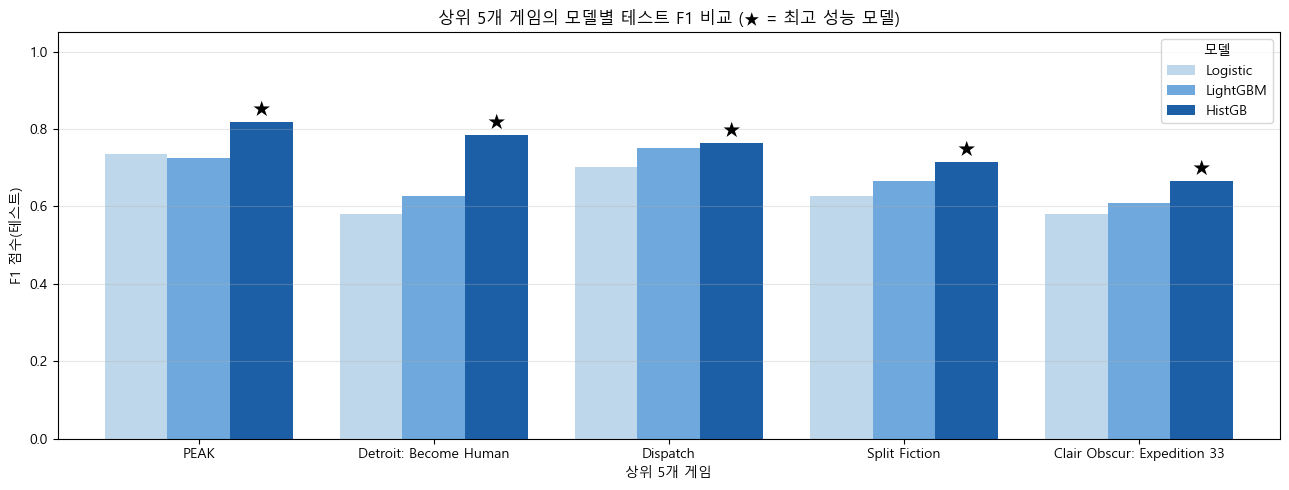

In [87]:
results_df = pd.DataFrame(results)

top5 = best_per_appid.sort_values(["test_f1", "test_recall"], ascending=False).head(5).copy()
top5_appids = top5["appid"].astype(int).tolist()

plot_df = results_df[results_df["appid"].isin(top5_appids)].copy()
pivot = plot_df.pivot_table(index="appid", columns="model", values="test_f1", aggfunc="mean")

model_order = list(models.keys())
pivot = pivot.reindex(columns=[m for m in model_order if m in pivot.columns])
pivot = pivot.reindex(index=top5_appids)

xlabels = [GAME_NAME_MAP.get(int(a), str(a)) for a in pivot.index]

x = np.arange(len(pivot.index))
n_models = len(pivot.columns)
width = 0.8 / max(n_models, 1)

fig, ax = plt.subplots(figsize=(13, 5))

# 막대 그리기
BLUE_PALETTE = ["#BFD7EA", "#6FA8DC", "#1D5FA7", "#0B3D91", "#A7C7E7"]

# 막대 그리기
for i, m in enumerate(pivot.columns):
    offsets = (i - (n_models - 1) / 2) * width
    ax.bar(
        x + offsets,
        pivot[m].values,
        width=width,
        label=m,
        color=BLUE_PALETTE[i % len(BLUE_PALETTE)]  # 여기만 추가
    )

# ★ 표시(최고 모델)
for j, appid in enumerate(pivot.index):
    row = pivot.loc[appid]
    if row.isna().all():
        continue
    best_m = row.idxmax()
    best_v = row.max()

    i_best = list(pivot.columns).index(best_m)
    best_offsets = (i_best - (n_models - 1) / 2) * width
    ax.text(x[j] + best_offsets, best_v + 0.01, "★", ha="center", va="bottom", fontsize=14)

# 핵심: tick을 그룹 중심(x)에 두고, 가운데 정렬
ax.set_xticks(x)
ax.set_xticklabels(xlabels, rotation=0, ha="center")

ax.set_xlim(-0.6, len(x) - 0.4)

ax.set_ylim(0, 1.05)
ax.set_ylabel("F1 점수(테스트)")
ax.set_xlabel("상위 5개 게임")
ax.set_title("상위 5개 게임의 모델별 테스트 F1 비교 (★ = 최고 성능 모델)")
ax.legend(title="모델")
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

[선정된 게임] Where Winds Meet | appid=3564740 | best_model(from results_df)=LightGBM | test_f1=0.6122
[로드 완료] model_name=LGBMClassifier | THR=0.5
[테스트셋] n=18726 | pred_pos_rate=0.4127 | churn_rate=0.3235


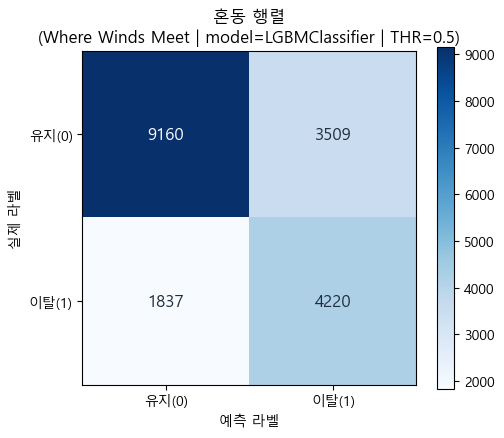

[CM] TN=9160, FP=3509, FN=1837, TP=4220


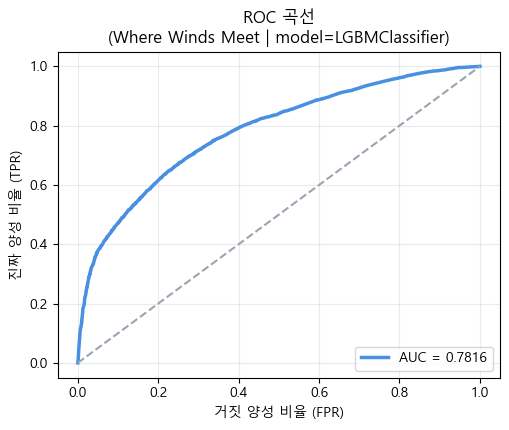

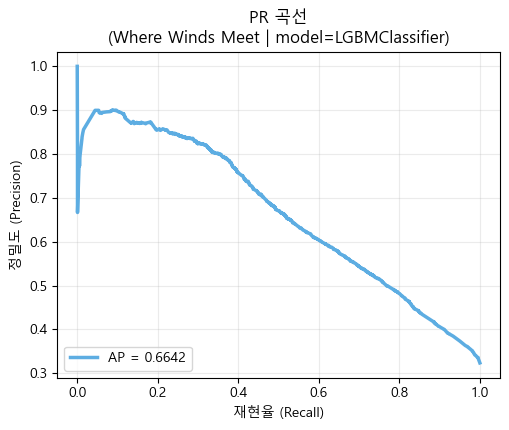

In [ ]:

# 1. 전제 체크
# 필요 변수: results_df, df_model, FEATURES, TARGET, TEST_SIZE, RANDOM_STATE, GAME_NAME_MAP
required = ["results_df","df_model","FEATURES","TARGET","TEST_SIZE","RANDOM_STATE","GAME_NAME_MAP"]
missing_vars = [v for v in required if v not in globals()]
if missing_vars:
    raise NameError(f"필수 변수가 없음: {missing_vars}")


# 2. 게임 1개 지정 (ROC/PR 균형 기준으로 직접 선택)
best_appid = 3564740   # 고른 appid로 고정
# results_df에서 이 appid의 row들(모델 3개)을 가져와서 참고용으로만 씀
cand = results_df[results_df["appid"] == best_appid].copy()
if cand.empty:
    raise ValueError(f"results_df에 appid={best_appid} 결과가 없음")

# 참고용: 이 appid에서 test_f1 최고 모델 이름
best_row = cand.sort_values(["test_f1","test_recall"], ascending=False).iloc[0]
best_model_name_from_df = str(best_row["model"])
game_name = GAME_NAME_MAP.get(best_appid, f"appid={best_appid}")

print(f"[선정된 게임] {game_name} | appid={best_appid} | "
      f"best_model(from results_df)={best_model_name_from_df} | test_f1={best_row['test_f1']:.4f}")



# 3. 해당 appid 모델 로드 (dict(payload) vs 모델객체 자동 처리)
obj = joblib.load(f"model/model_{best_appid}.pkl")

if isinstance(obj, dict):
    model = obj.get("model", None)
    THR = float(obj.get("best_thr", 0.5))
    model_name = str(obj.get("model_name", best_model_name_from_df))
else:
    model = obj
    THR = 0.5
    model_name = type(model).__name__

if model is None:
    raise ValueError(f"model/model_{best_appid}.pkl 이 dict인데 'model' 키가 없음. keys={list(obj.keys())}")

print(f"[로드 완료] model_name={model_name} | THR={THR}")


# 4. 동일 split으로 테스트셋 재구성 + 예측
gdf = df_model[df_model["appid"] == best_appid].copy()
gdf = gdf.replace([np.inf, -np.inf], 0)

if gdf[TARGET].nunique() < 2:
    raise ValueError(f"appid={best_appid} 는 TARGET이 한쪽 클래스만 존재해서 그래프 불가")

X = gdf[FEATURES]
y = gdf[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

# 확률/예측
y_proba = model.predict_proba(X_test)[:, 1]
y_pred  = (y_proba >= THR).astype(int)

print(f"[테스트셋] n={len(y_test)} | pred_pos_rate={float(np.mean(y_pred==1)):.4f} | churn_rate={float(y.mean()):.4f}")


# 5. 그래프 공통 스타일(블루 기반)
BLUE_LINE = "#4A90E2"   # 선(연한 블루)
BLUE_LINE2 = "#5DADE2"  # PR용 약간 다른 블루
GRID_C = "#9AA5B1"


# 6. 혼동행렬 (Confusion Matrix)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

plt.figure(figsize=(5.2, 4.4))
plt.imshow(cm, interpolation="nearest", cmap="Blues")  # ✅ 블루 계열
plt.title(f"혼동 행렬\n({game_name} | model={model_name} | THR={THR})")
plt.colorbar()

classes = ["유지(0)", "이탈(1)"]
plt.xticks([0, 1], classes)
plt.yticks([0, 1], classes)

th = cm.max() / 2.0
for i in range(2):
    for j in range(2):
        plt.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color=("white" if cm[i, j] > th else "#1f2d3d"),
            fontsize=12
        )

plt.xlabel("예측 라벨")
plt.ylabel("실제 라벨")
plt.tight_layout()
plt.show()

print(f"[CM] TN={tn}, FP={fp}, FN={fn}, TP={tp}")

# 7. ROC 곡선
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5.2, 4.4))
plt.plot(fpr, tpr, color=BLUE_LINE, linewidth=2.5, label=f"AUC = {roc_auc:.4f}")  # ✅ 블루
plt.plot([0, 1], [0, 1], linestyle="--", color=GRID_C, linewidth=1.5)

plt.title(f"ROC 곡선\n({game_name} | model={model_name})")
plt.xlabel("거짓 양성 비율 (FPR)")
plt.ylabel("진짜 양성 비율 (TPR)")
plt.grid(alpha=0.25)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


# 8. PR 곡선
prec, rec, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure(figsize=(5.2, 4.4))
plt.plot(rec, prec, color=BLUE_LINE2, linewidth=2.5, label=f"AP = {ap:.4f}")  # ✅ 블루
plt.title(f"PR 곡선\n({game_name} | model={model_name})")
plt.xlabel("재현율 (Recall)")
plt.ylabel("정밀도 (Precision)")
plt.grid(alpha=0.25)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


In [ ]:
# 1차 (임계값 0.5 고정) 결과: appid별 best만 남긴 것
df_stage1 = best_per_appid

# 2차 (하이퍼 + best_thr) 결과
df_stage2 = tuned_df

# 3차 (SMOTE + best_threshold) 결과
df_stage3 = smote_df

# SMOTE로 선정된 5개 appid 
smote_appids = smote_df["appid"].astype(int).tolist()



In [ ]:
def pick_best_per_appid(df, appids, f1_col="test_f1"):
    # appid 필터 후, appid별 test_f1 가장 높은 1개 row만 선택
    sub = df[df["appid"].isin(appids)].copy()
    sub = sub.sort_values([f1_col], ascending=False)
    sub = sub.groupby("appid", as_index=False).head(1)
    return sub

def standardize_stage(df, stage_name, appids, model_col, thr_value=None, thr_col=None):
    dfb = pick_best_per_appid(df, appids)

    # threshold 만들기
    if thr_col is not None and thr_col in dfb.columns:
        dfb["thr"] = dfb[thr_col].astype(float)
    else:
        dfb["thr"] = float(thr_value) if thr_value is not None else 0.5

    # model 이름
    dfb["model_name"] = dfb[model_col].astype(str)

    # game name
    dfb["game_name"] = dfb["appid"].map(lambda a: GAME_NAME_MAP.get(int(a), str(int(a))))

    # stage
    dfb["stage"] = stage_name

    keep_cols = [
        "appid", "game_name", "stage", "model_name", "thr",
        "test_acc", "test_precision", "test_recall", "test_f1"
    ]

    # 혹시 컬럼이 없으면 에러 내서 바로 잡게
    missing = [c for c in keep_cols if c not in dfb.columns]
    if missing:
        raise KeyError(f"[{stage_name}] 필요한 컬럼이 DF에 없음: {missing}\n현재 컬럼: {list(dfb.columns)}")

    return dfb[keep_cols].copy()


# S1: 1차(THR=0.5 고정)
s1 = standardize_stage(
    df_stage1, stage_name="S1(기본, THR=0.5)",
    appids=smote_appids,
    model_col="model",
    thr_value=0.5
)

# S2: 그리드서치/튜닝(best_thr 사용)
s2 = standardize_stage(
    df_stage2, stage_name="S2(튜닝+best_thr)",
    appids=smote_appids,
    model_col="model",
    thr_col="best_thr"
)

# S3: SMOTE(best_threshold 사용, 모델 컬럼명 best_model)
s3 = standardize_stage(
    df_stage3, stage_name="S3(SMOTE+best_thr)",
    appids=smote_appids,
    model_col="best_model",
    thr_col="best_threshold"
)

summary_long = pd.concat([s1, s2, s3], ignore_index=True)

# 보기 좋게 정렬
summary_long["appid"] = summary_long["appid"].astype(int)
summary_long = summary_long.sort_values(["appid", "stage"]).reset_index(drop=True)

display(summary_long)


,appid,game_name,stage,model_name,thr,test_acc,test_precision,test_recall,test_f1
0,730,Counter-Strike 2,"S1(기본, THR=0.5)",LightGBM,0.50,0.619084,0.253723,0.546203,0.346493
1,730,Counter-Strike 2,S2(튜닝+best_thr),LightGBM,0.46,0.524360,0.233599,0.689529,0.348973
2,730,Counter-Strike 2,S3(SMOTE+best_thr),RandomForest,0.48,0.560455,0.238230,0.626799,0.345242
3,553850,HELLDIVERS 2,"S1(기본, THR=0.5)",LightGBM,0.50,0.664764,0.235937,0.628821,0.343129
4,553850,HELLDIVERS 2,S2(튜닝+best_thr),LightGBM,0.58,0.782860,0.307577,0.447113,0.364445
5,553850,HELLDIVERS 2,S3(SMOTE+best_thr),RandomForest,0.56,0.780056,0.300418,0.436196,0.355793
6,1808500,ARC Raiders,"S1(기본, THR=0.5)",LightGBM,0.50,0.688541,0.303526,0.516458,0.382345
7,1808500,ARC Raiders,S2(튜닝+best_thr),LightGBM,0.50,0.685845,0.303597,0.527925,0.385501
8,1808500,ARC Raiders,S3(SMOTE+best_thr),RandomForest,0.50,0.695041,0.307190,0.504884,0.381974
9,1973530,Limbus Company,"S1(기본, THR=0.5)",LightGBM,0.50,0.773830,0.218333,0.653793,0.327348


In [ ]:
# import numpy as np
# import pandas as pd
# import joblib
# from sklearn.model_selection import train_test_split

# appid = int(top_appids[0])  # 원하는 appid로 변경 가능

# obj = joblib.load(f"model/model_{appid}.pkl")

# # (핵심) 저장 형태가 dict(payload)인지, 모델 객체인지 자동 분기
# if isinstance(obj, dict):
#     model = obj.get("model", None)
#     THR = float(obj.get("best_thr", 0.5))
#     model_name = obj.get("model_name", "unknown")
# else:
#     model = obj
#     THR = 0.5
#     model_name = type(model).__name__

# if model is None:
#     raise ValueError(f"model/model_{appid}.pkl 안에 'model' 키가 없거나 비어있음. keys={list(obj.keys())}")

# # 3) 해당 appid 데이터만 뽑기
# gdf = df_model[df_model["appid"] == appid].copy()
# gdf = gdf.replace([np.inf, -np.inf], 0)

# if gdf[TARGET].nunique() < 2:
#     raise ValueError(f"appid={appid} 는 TARGET이 한쪽 클래스만 존재해서 그래프 불가")

# X = gdf[FEATURES]
# y = gdf[TARGET].astype(int)

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=TEST_SIZE,
#     random_state=RANDOM_STATE,
#     stratify=y
# )

# # 확률/예측 만들기
# # Pipeline/LightGBM/HistGB는 predict_proba 있음
# y_proba = model.predict_proba(X_test)[:, 1]
# y_pred = (y_proba >= THR).astype(int)

# print("appid:", appid)
# print("loaded_type:", type(obj))
# print("model_name:", model_name, "| model_type:", type(model))
# print("THR:", THR, "| test size:", len(y_test), "| pred_pos_rate:", float(np.mean(y_pred==1)))

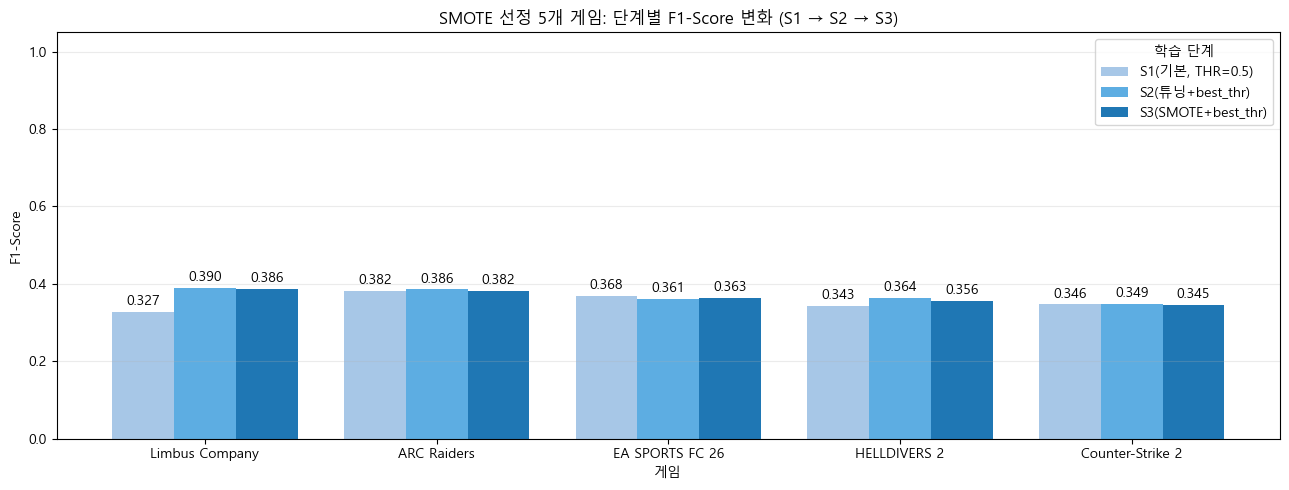

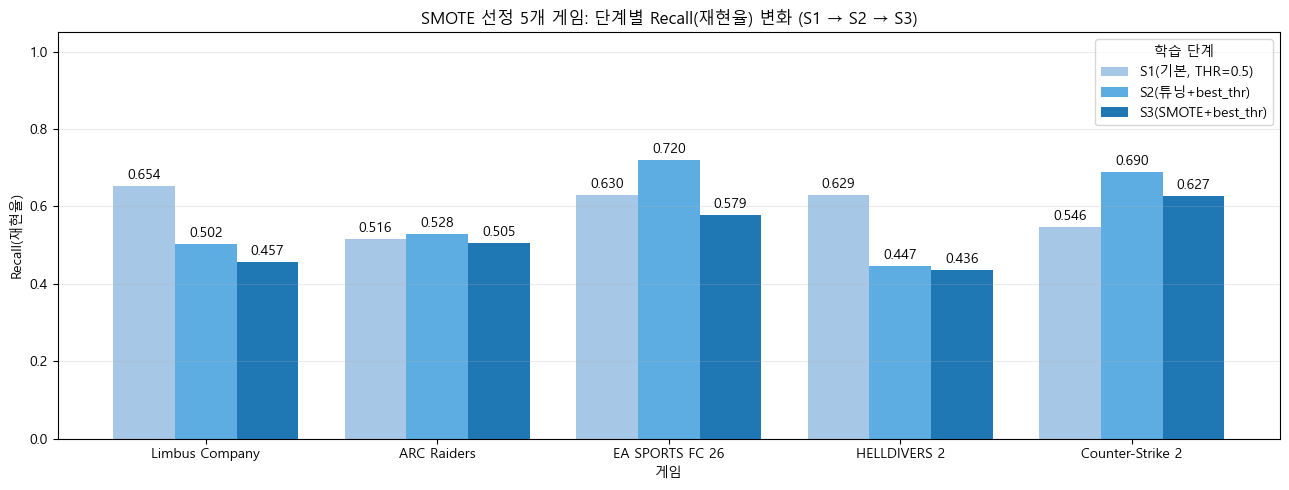

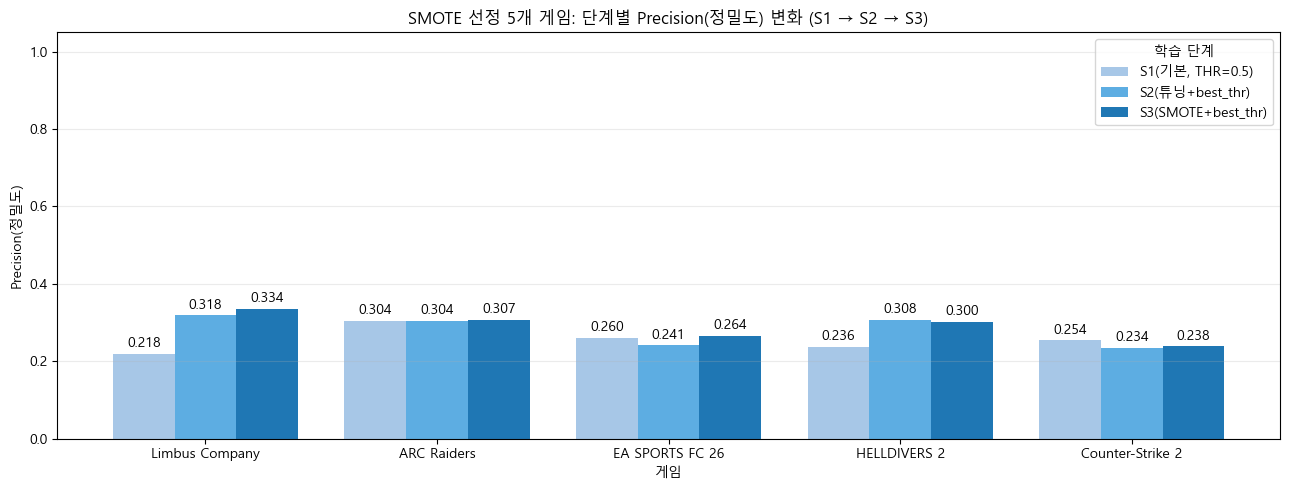

In [ ]:
import matplotlib.pyplot as plt

# 블루 3톤
STAGE_COLORS = {
    "S1(기본, THR=0.5)": "#A7C7E7",   # 연한 블루
    "S2(튜닝+best_thr)": "#5DADE2",   # 중간 블루
    "S3(SMOTE+best_thr)": "#1F77B4",  # 진한 블루
}

def plot_stage_bars(df_long, metric_col, metric_label):
    stages = ["S1(기본, THR=0.5)", "S2(튜닝+best_thr)", "S3(SMOTE+best_thr)"]
    appids = smote_appids[:]  # 고정 순서
    game_labels = [GAME_NAME_MAP.get(int(a), str(int(a))) for a in appids]

    # pivot: index=appid, columns=stage, values=metric
    pv = df_long.pivot_table(index="appid", columns="stage", values=metric_col, aggfunc="first")
    pv = pv.reindex(index=appids, columns=stages)

    x = np.arange(len(appids))
    width = 0.8 / len(stages)

    fig, ax = plt.subplots(figsize=(13, 5))

    for i, st in enumerate(stages):
        vals = pv[st].values
        offset = (i - (len(stages)-1)/2) * width
        bars = ax.bar(x + offset, vals, width=width, label=st, color=STAGE_COLORS[st])

        # 값 라벨(선택)
        for b, v in zip(bars, vals):
            if pd.isna(v): 
                continue
            ax.text(b.get_x() + b.get_width()/2, v + 0.01, f"{v:.3f}", ha="center", va="bottom", fontsize=10)

    ax.set_xticks(x)
    ax.set_xticklabels(game_labels, rotation=0, ha="center")

    ax.set_ylim(0, 1.05)
    ax.set_ylabel(metric_label)
    ax.set_xlabel("게임")
    ax.set_title(f"SMOTE 선정 5개 게임: 단계별 {metric_label} 변화 (S1 → S2 → S3)")
    ax.grid(axis="y", alpha=0.25)
    ax.legend(title="학습 단계")

    plt.tight_layout()
    plt.show()

# 바 그래프 3개
plot_stage_bars(summary_long, "test_f1", "F1-Score")
plot_stage_bars(summary_long, "test_recall", "Recall(재현율)")
plot_stage_bars(summary_long, "test_precision", "Precision(정밀도)")
